# Multimodal Property Price Prediction with Satellite Imagery

In [1]:
# Multimodal Property Price Prediction with Satellite Imagery
# Combining Tabular Data + Satellite Images for Property Valuation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torchvision.models as models

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA

# Advanced Models
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available")

try:
    from lightgbm import LGBMRegressor
    LIGHTGBM_AVAILABLE = True
except:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not available")

try:
    from catboost import CatBoostRegressor
    CATBOOST_AVAILABLE = True
except:
    CATBOOST_AVAILABLE = False
    print("CatBoost not available")

# For Grad-CAM
from torch.autograd import Variable

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("=" * 80)
print("MULTIMODAL PROPERTY VALUATION")
print("Satellite Imagery + Tabular Data")
print("=" * 80)


Using device: cuda
GPU: NVIDIA RTX 6000 Ada Generation
Memory: 51.00 GB
MULTIMODAL PROPERTY VALUATION
Satellite Imagery + Tabular Data


### 1. CONFIGURATION

In [2]:
# ============================================================================
# 1. CONFIGURATION
# ============================================================================

print("\n[1] Configuration Settings")

class Config:
    # Paths
    TRAIN_DATA_PATH = 'train.csv'
    TEST_DATA_PATH = 'test.csv'
    TRAIN_IMAGE_DIR = 'images/train'
    TEST_IMAGE_DIR = 'images/test'
    
    # Image settings
    IMAGE_SIZE = 224  # Resize to 224x224 for pre-trained models
    BATCH_SIZE = 32
    NUM_WORKERS = 6
    
    # Training settings
    EPOCHS = 20
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-4
    
    # Model settings
    FEATURE_DIM = 512  # Dimension of extracted features
    
    # Save paths
    MODEL_SAVE_DIR = 'models'
    RESULTS_DIR = 'results'
    
    def __init__(self):
        os.makedirs(self.MODEL_SAVE_DIR, exist_ok=True)
        os.makedirs(self.RESULTS_DIR, exist_ok=True)

config = Config()
print(f"Image size: {config.IMAGE_SIZE}x{config.IMAGE_SIZE}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Device: {device}")


[1] Configuration Settings
Image size: 224x224
Batch size: 32
Device: cuda


### 2. LOAD AND PREPARE TABULAR DATA (with Feature Engineering)

In [3]:
# ============================================================================
# 2. LOAD AND PREPARE TABULAR DATA (with Feature Engineering)
# ============================================================================

# print("\n" + "=" * 80)
# print("[2] LOADING AND ENGINEERING TABULAR DATA")
# print("=" * 80)

# def engineer_features(df, is_train=True):
#     """
#     Create new features from existing ones
#     """
#     df = df.copy()
    
#     print("Engineering features...")
    
#     # Basic Features
#     if 'bedrooms' in df.columns and 'bathrooms' in df.columns:
#         df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
#     if 'sqft_living' in df.columns and 'sqft_lot' in df.columns:
#         df['living_lot_ratio'] = df['sqft_living'] / (df['sqft_lot'] + 1)
    
#     if 'sqft_basement' in df.columns:
#         df['has_basement'] = (df['sqft_basement'] > 0).astype(int)
    
#     if 'sqft_above' in df.columns and 'sqft_living' in df.columns:
#         df['above_ratio'] = df['sqft_above'] / (df['sqft_living'] + 1)
    
#     # Neighborhood Features
#     if 'sqft_living15' in df.columns and 'sqft_living' in df.columns:
#         df['living_vs_neighbors'] = df['sqft_living'] / (df['sqft_living15'] + 1)
    
#     if 'sqft_lot15' in df.columns and 'sqft_lot' in df.columns:
#         df['lot_vs_neighbors'] = df['sqft_lot'] / (df['sqft_lot15'] + 1)
    
#     # Quality Features
#     if 'grade' in df.columns and 'condition' in df.columns:
#         df['quality_score'] = df['grade'] * df['condition']
    
#     # Age Features
#     if 'yr_built' in df.columns:
#         current_year = 2026
#         df['property_age'] = current_year - df['yr_built']
#         df['property_age'] = df['property_age'].clip(lower=0)
    
#     if 'yr_renovated' in df.columns:
#         df['was_renovated'] = (df['yr_renovated'] > 0).astype(int)
#         if 'yr_built' in df.columns:
#             df['years_since_renovation'] = current_year - df['yr_renovated']
#             df.loc[df['yr_renovated'] == 0, 'years_since_renovation'] = df['property_age']
    
#     # Location Features
#     if 'lat' in df.columns and 'long' in df.columns:
#         city_center_lat = 47.6062
#         city_center_long = -122.3321
#         df['dist_from_center'] = np.sqrt(
#             (df['lat'] - city_center_lat)**2 + 
#             (df['long'] - city_center_long)**2
#         )
    
#     # Interaction Features
#     if 'bedrooms' in df.columns and 'sqft_living' in df.columns:
#         df['sqft_per_bedroom'] = df['sqft_living'] / (df['bedrooms'] + 1)
    
#     if 'bathrooms' in df.columns and 'sqft_living' in df.columns:
#         df['sqft_per_bathroom'] = df['sqft_living'] / (df['bathrooms'] + 1)
    
#     if 'grade' in df.columns and 'sqft_living' in df.columns:
#         df['luxury_score'] = df['grade'] * np.log1p(df['sqft_living'])
    
#     if 'view' in df.columns and 'waterfront' in df.columns:
#         df['premium_view'] = df['view'] * (df['waterfront'] + 1)
    
#     return df

# # Load data
# print("\nLoading datasets...")
# train_df = pd.read_csv(config.TRAIN_DATA_PATH)
# test_df = pd.read_csv(config.TEST_DATA_PATH)

# print(f"Train shape: {train_df.shape}")
# print(f"Test shape: {test_df.shape}")

# # Apply feature engineering
# train_df = engineer_features(train_df, is_train=True)
# test_df = engineer_features(test_df, is_train=False)

train_df = pd.read_csv("train_engineered.csv", index_col=0).squeeze()
test_df = pd.read_csv("test_engineered.csv", index_col=0).squeeze()


# Handle missing values
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_exclude = ['id', 'price']
numerical_cols = [col for col in numerical_cols if col not in cols_to_exclude]

for col in numerical_cols:
    if train_df[col].isnull().sum() > 0:
        median_val = train_df[col].median()
        train_df[col].fillna(median_val, inplace=True)
        test_df[col].fillna(median_val, inplace=True)

# Prepare features
X_tabular = train_df.drop(['price', 'id'], axis=1, errors='ignore')
y = train_df['price'].values
X_test_tabular = test_df.drop(['id'], axis=1, errors='ignore')

# Remove date columns
date_cols = X_tabular.select_dtypes(include=['datetime64']).columns.tolist()
date_cols.append('date')
print("date_cols")
print(date_cols)
X_tabular = X_tabular.drop(date_cols, axis=1, errors='ignore')
X_test_tabular = X_test_tabular.drop(date_cols, axis=1, errors='ignore')

# Ensure same columns
common_cols = list(set(X_tabular.columns) & set(X_test_tabular.columns))
X_tabular = X_tabular[common_cols]
X_test_tabular = X_test_tabular[common_cols]

print(f"\nTabular features shape: {X_tabular.shape}")
print(f"Target shape: {y.shape}")

# Split train/validation
X_tab_train, X_tab_val, y_train, y_val, train_ids, val_ids = train_test_split(
    X_tabular, y, train_df['id'], test_size=0.2, random_state=42
)

print(f"Train samples: {len(X_tab_train)}")
print(f"Validation samples: {len(X_tab_val)}")

# Scale tabular features
scaler = RobustScaler()
X_tab_train_scaled = scaler.fit_transform(X_tab_train)
X_tab_val_scaled = scaler.transform(X_tab_val)
X_test_tabular_scaled = scaler.transform(X_test_tabular)

print("Tabular data prepared successfully!")


date_cols
['date']

Tabular features shape: (16209, 37)
Target shape: (16209,)
Train samples: 12967
Validation samples: 3242
Tabular data prepared successfully!


In [4]:
X_tab_train.columns

Index(['long', 'bathrooms', 'grade', 'sqft_lot15', 'quality_score',
       'living_lot_ratio', 'quarter_sold', 'waterfront', 'yr_built',
       'yr_renovated', 'sqft_above', 'sqft_basement', 'total_rooms',
       'sqft_per_bathroom', 'luxury_score', 'living_vs_neighbors',
       'dist_from_center', 'age_at_sale', 'lat', 'view', 'has_basement',
       'premium_view', 'lot_vs_neighbors', 'bedrooms', 'floors', 'sqft_lot',
       'sqft_living15', 'sqft_living', 'property_age', 'month_sold',
       'condition', 'above_ratio', 'years_since_renovation', 'was_renovated',
       'year_sold', 'zipcode', 'sqft_per_bedroom'],
      dtype='object')

In [5]:
print(X_tab_train.head())

          long  bathrooms  grade  sqft_lot15  quality_score  living_lot_ratio  \
4140  -121.827       1.00      6        6600             18          0.184820   
1510  -122.315       2.00      7        4650             21          0.529226   
6706  -122.065       2.50      9        6866             27          0.322015   
11009 -122.278       2.25     10       10027             50          0.241537   
6554  -121.905       5.25     10       68824             30          0.016328   

       quarter_sold  waterfront  yr_built  yr_renovated  sqft_above  \
4140              3           0      1958             0        1220   
1510              3           0      1922          2004        1450   
6706              4           0      1998             0        2570   
11009             2           0      1953             0        1980   
6554              3           0      2006             0        5240   

       sqft_basement  total_rooms  sqft_per_bathroom  luxury_score  \
4140            

### 3. IMAGE DATA PREPARATION

In [6]:
# ============================================================================
# 3. IMAGE DATA PREPARATION
# ============================================================================

print("\n" + "=" * 80)
print("[3] IMAGE DATA PREPARATION")
print("=" * 80)

# Check image availability
print("\nChecking image files...")
train_images_exist = sum([os.path.exists(f"{config.TRAIN_IMAGE_DIR}/{id}.jpg") for id in train_df['id']])
test_images_exist = sum([os.path.exists(f"{config.TEST_IMAGE_DIR}/{id}.jpg") for id in test_df['id']])

print(f"Training images found: {train_images_exist}/{len(train_df)} ({100*train_images_exist/len(train_df):.2f}%)")
print(f"Test images found: {test_images_exist}/{len(test_df)} ({100*test_images_exist/len(test_df):.2f}%)")

# Data augmentation and preprocessing
train_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Image transformations configured:")
print("- Training: Augmentation enabled (flips, rotation, color jitter)")
print("- Validation/Test: Standard normalization only")

# Custom Dataset
class PropertyDataset(Dataset):
    def __init__(self, ids, tabular_features, targets, image_dir, transform=None):
        self.ids = ids.values if hasattr(ids, 'values') else ids
        self.tabular_features = tabular_features
        self.targets = targets
        self.image_dir = image_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        # Load image
        img_path = f"{self.image_dir}/{self.ids[idx]}.jpg"
        
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except:
            # If image not found, create a blank image
            image = torch.zeros(3, config.IMAGE_SIZE, config.IMAGE_SIZE)
        
        # Get tabular features
        tabular = torch.FloatTensor(self.tabular_features[idx])
        
        # Get target
        target = torch.FloatTensor([self.targets[idx]])
        
        return image, tabular, target, self.ids[idx]

# Function to save datasets
def save_datasets(train_dataset, val_dataset, test_dataset, save_dir='datasets'):
    """Save datasets to disk for later reuse"""
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"\nSaving datasets to {save_dir}/...")
    
    # Save dataset components
    dataset_data = {
        'train': {
            'ids': train_dataset.ids,
            'tabular_features': train_dataset.tabular_features,
            'targets': train_dataset.targets,
            'image_dir': train_dataset.image_dir
        },
        'val': {
            'ids': val_dataset.ids,
            'tabular_features': val_dataset.tabular_features,
            'targets': val_dataset.targets,
            'image_dir': val_dataset.image_dir
        },
        'test': {
            'ids': test_dataset.ids,
            'tabular_features': test_dataset.tabular_features,
            'targets': test_dataset.targets,
            'image_dir': test_dataset.image_dir
        }
    }
    
    torch.save(dataset_data, f"{save_dir}/datasets.pt")
    print(f"✓ Datasets saved successfully")

# Function to load datasets
def load_datasets(save_dir='datasets', train_transform=None, val_transform=None):
    """Load saved datasets from disk"""
    print(f"\nLoading datasets from {save_dir}/...")
    
    dataset_data = torch.load(f"{save_dir}/datasets.pt", weights_only=False)
    
    # Recreate datasets
    train_dataset = PropertyDataset(
        dataset_data['train']['ids'],
        dataset_data['train']['tabular_features'],
        dataset_data['train']['targets'],
        dataset_data['train']['image_dir'],
        train_transform
    )
    
    val_dataset = PropertyDataset(
        dataset_data['val']['ids'],
        dataset_data['val']['tabular_features'],
        dataset_data['val']['targets'],
        dataset_data['val']['image_dir'],
        val_transform
    )
    
    test_dataset = PropertyDataset(
        dataset_data['test']['ids'],
        dataset_data['test']['tabular_features'],
        dataset_data['test']['targets'],
        dataset_data['test']['image_dir'],
        val_transform
    )
    
    print(f"✓ Datasets loaded successfully")
    return train_dataset, val_dataset, test_dataset

if not os.path.exists(f"datasets/datasets.pt"):
    # Create datasets
    train_dataset = PropertyDataset(
        train_ids, X_tab_train_scaled, y_train,
        config.TRAIN_IMAGE_DIR, train_transform
    )

    val_dataset = PropertyDataset(
        val_ids, X_tab_val_scaled, y_val,
        config.TRAIN_IMAGE_DIR, val_transform
    )

    test_dataset = PropertyDataset(
        test_df['id'], X_test_tabular_scaled, np.zeros(len(test_df)),
        config.TEST_IMAGE_DIR, val_transform
    )

    # Save datasets for later reuse
    save_datasets(train_dataset, val_dataset, test_dataset)
    print("dataset saved successfully!!!")
else:
    print("dataset already exists.")
    print("Datasets ready to load")




[3] IMAGE DATA PREPARATION

Checking image files...
Training images found: 16209/16209 (100.00%)
Test images found: 5404/5404 (100.00%)
Image transformations configured:
- Training: Augmentation enabled (flips, rotation, color jitter)
- Validation/Test: Standard normalization only
dataset already exists.
Datasets ready to load


In [7]:
# ============================================================================
# TO LOAD DATASETS LATER:
# ============================================================================
train_dataset, val_dataset, test_dataset = load_datasets(
    save_dir='datasets',
    train_transform=train_transform,
    val_transform=val_transform
)
# Create dataloaders
train_loader = DataLoader(
    train_dataset, batch_size=config.BATCH_SIZE,
    shuffle=True, num_workers=config.NUM_WORKERS, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=config.BATCH_SIZE,
    shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=True
)

test_loader = DataLoader(
    test_dataset, batch_size=config.BATCH_SIZE,
    shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=True
)

print(f"\nDataLoaders created:")
print(f"- Train batches: {len(train_loader)}")
print(f"- Validation batches: {len(val_loader)}")
print(f"- Test batches: {len(test_loader)}")


Loading datasets from datasets/...


✓ Datasets loaded successfully

DataLoaders created:
- Train batches: 406
- Validation batches: 102
- Test batches: 169


### 4. CNN FEATURE EXTRACTORS

In [8]:
# ============================================================================
# 4. CNN FEATURE EXTRACTORS
# ============================================================================

print("\n" + "=" * 80)
print("[4] BUILDING CNN FEATURE EXTRACTORS")
print("=" * 80)

class CNNFeatureExtractor(nn.Module):
    """Base class for CNN feature extractors"""
    def __init__(self, backbone_name='resnet50', pretrained=True, feature_dim=512):
        super(CNNFeatureExtractor, self).__init__()
        self.backbone_name = backbone_name
        self.feature_dim = feature_dim
        
        if backbone_name == 'resnet50':
            backbone = models.resnet50(pretrained=pretrained)
            self.features = nn.Sequential(*list(backbone.children())[:-1])
            backbone_out_dim = 2048
            
        elif backbone_name == 'efficientnet':
            backbone = models.efficientnet_b3(pretrained=pretrained)
            self.features = nn.Sequential(*list(backbone.children())[:-1])
            backbone_out_dim = 1536
            
        elif backbone_name == 'vgg16':
            backbone = models.vgg16(pretrained=pretrained)
            self.features = backbone.features
            self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
            backbone_out_dim = 512 * 7 * 7
        
        # Projection layer to reduce dimensions
        self.projection = nn.Sequential(
            nn.Linear(backbone_out_dim, feature_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
    def forward(self, x):
        x = self.features(x)
        
        if self.backbone_name == 'vgg16':
            x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        x = self.projection(x)
        return x

print("Creating CNN architectures...")
print("1. ResNet50")
print("2. EfficientNet-B3")
print("3. VGG16")



[4] BUILDING CNN FEATURE EXTRACTORS
Creating CNN architectures...
1. ResNet50
2. EfficientNet-B3
3. VGG16


### 5. MULTIMODAL FUSION ARCHITECTURES

#### 5.1 Early Fusion

In [9]:
# ============================================================================
# 5. MULTIMODAL FUSION ARCHITECTURES
# ============================================================================

print("\n" + "=" * 80)
print("[5] MULTIMODAL FUSION ARCHITECTURES")
print("=" * 80)

# 5.1 Early Fusion
class EarlyFusionModel(nn.Module):
    """Concatenate image and tabular features early, then predict"""
    def __init__(self, cnn_backbone, tabular_dim, feature_dim=512):
        super(EarlyFusionModel, self).__init__()
        self.cnn = CNNFeatureExtractor(cnn_backbone, pretrained=True, feature_dim=feature_dim)
        self.tabular_dim = tabular_dim
        
        # Combined feature processing
        combined_dim = feature_dim + tabular_dim
        self.fusion = nn.Sequential(
            nn.Linear(combined_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, image, tabular):
        # Extract image features
        img_features = self.cnn(image)
        
        # Concatenate
        combined = torch.cat([img_features, tabular], dim=1)
        
        # Predict
        output = self.fusion(combined)
        return output

print("✓ Early Fusion Architecture")


[5] MULTIMODAL FUSION ARCHITECTURES
✓ Early Fusion Architecture


#### 5.2 Late Fusion

In [10]:
# 5.2 Late Fusion
class LateFusionModel(nn.Module):
    """Train separate branches for image and tabular, combine predictions"""
    def __init__(self, cnn_backbone, tabular_dim, feature_dim=512):
        super(LateFusionModel, self).__init__()
        self.cnn = CNNFeatureExtractor(cnn_backbone, pretrained=True, feature_dim=feature_dim)
        
        # Image branch
        self.image_branch = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
        # Tabular branch
        self.tabular_branch = nn.Sequential(
            nn.Linear(tabular_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
        # Fusion weights (learnable)
        self.alpha = nn.Parameter(torch.tensor(0.5))
        
    def forward(self, image, tabular):
        # Extract image features
        img_features = self.cnn(image)
        
        # Get predictions from each branch
        img_pred = self.image_branch(img_features)
        tab_pred = self.tabular_branch(tabular)
        
        # Weighted combination
        alpha = torch.sigmoid(self.alpha)
        output = alpha * img_pred + (1 - alpha) * tab_pred
        
        return output

print("✓ Late Fusion Architecture")

✓ Late Fusion Architecture


#### 5.3 Hybrid Fusion

In [11]:
# 5.3 Hybrid Fusion
class HybridFusionModel(nn.Module):
    """Multiple fusion points - combines early and late fusion"""
    def __init__(self, cnn_backbone, tabular_dim, feature_dim=512):
        super(HybridFusionModel, self).__init__()
        self.cnn = CNNFeatureExtractor(cnn_backbone, pretrained=True, feature_dim=feature_dim)
        
        # Tabular processing
        self.tabular_encoder = nn.Sequential(
            nn.Linear(tabular_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Early fusion path
        self.early_fusion = nn.Sequential(
            nn.Linear(feature_dim + 256, 384),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Late fusion paths
        self.image_path = nn.Sequential(
            nn.Linear(feature_dim, 192),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.tabular_path = nn.Sequential(
            nn.Linear(256, 192),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Final prediction
        self.final_fusion = nn.Sequential(
            nn.Linear(384 + 192 + 192, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, image, tabular):
        # Extract features
        img_features = self.cnn(image)
        tab_features = self.tabular_encoder(tabular)
        
        # Early fusion
        early = self.early_fusion(torch.cat([img_features, tab_features], dim=1))
        
        # Late fusion
        img_path = self.image_path(img_features)
        tab_path = self.tabular_path(tab_features)
        
        # Combine all paths
        combined = torch.cat([early, img_path, tab_path], dim=1)
        output = self.final_fusion(combined)
        
        return output

print("✓ Hybrid Fusion Architecture")


✓ Hybrid Fusion Architecture


### 6. TRAINING UTILITIES

In [12]:
# ============================================================================
# 6. TRAINING UTILITIES
# ============================================================================

print("\n" + "=" * 80)
print("[6] TRAINING UTILITIES")
print("=" * 80)

class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    for images, tabular, targets, _ in loader:
        images = images.to(device)
        tabular = tabular.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(images, tabular)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for images, tabular, targets, _ in loader:
            images = images.to(device)
            tabular = tabular.to(device)
            targets = targets.to(device)
            
            outputs = model(images, tabular)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    
    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()
    
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    return total_loss / len(loader), rmse, mae, r2, predictions, actuals

def train_model(model, train_loader, val_loader, epochs, lr, device, model_name):
    """Complete training loop"""
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print(f"{'='*60}")
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=config.WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    early_stopping = EarlyStopping(patience=5)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_rmse': [],
        'val_mae': [],
        'val_r2': []
    }
    
    best_rmse = float('inf')
    
    for epoch in range(epochs):
        # Train
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_rmse, val_mae, val_r2, _, _ = validate(model, val_loader, criterion, device)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_rmse'].append(val_rmse)
        history['val_mae'].append(val_mae)
        history['val_r2'].append(val_r2)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f} | RMSE: ${val_rmse:,.2f} | MAE: ${val_mae:,.2f} | R²: {val_r2:.4f}")
        
        # Save best model
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            torch.save(model.state_dict(), f"{config.MODEL_SAVE_DIR}/{model_name}_best.pth")
            print(f"  ✓ Saved best model (RMSE: ${best_rmse:,.2f})")
        
        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"  Early stopping triggered at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(torch.load(f"{config.MODEL_SAVE_DIR}/{model_name}_best.pth"))
    
    return model, history

print("Training utilities configured:")
print("- Early stopping (patience=5)")
print("- Learning rate scheduler")
print("- MSE Loss function")
print("- Adam optimizer")



[6] TRAINING UTILITIES
Training utilities configured:
- Early stopping (patience=5)
- Learning rate scheduler
- MSE Loss function
- Adam optimizer


### 7. TRAIN ALL FUSION MODELS

#### 7.1 Early Fusion Models

In [13]:
# ============================================================================
# 7. TRAIN ALL FUSION MODELS
# ============================================================================

print("\n" + "=" * 80)
print("[7] TRAINING MULTIMODAL MODELS")
print("=" * 80)

tabular_dim = X_tab_train_scaled.shape[1]
all_models = {}
all_histories = {}

# 7.1 Early Fusion Models
print("\n" + "="*60)
print("EARLY FUSION MODELS")
print("="*60)

for backbone in ['resnet50', 'efficientnet', 'vgg16']:
    model_name = f"EarlyFusion_{backbone}"
    print(f"\n>>> Training {model_name}...")
    
    model = EarlyFusionModel(backbone, tabular_dim, feature_dim=config.FEATURE_DIM).to(device)
    model, history = train_model(model, train_loader, val_loader, config.EPOCHS, config.LEARNING_RATE, device, model_name)
    
    all_models[model_name] = model
    all_histories[model_name] = history

print("Early Fusion Models trained")


[7] TRAINING MULTIMODAL MODELS

EARLY FUSION MODELS

>>> Training EarlyFusion_resnet50...



Training: EarlyFusion_resnet50


Epoch 1/20
  Train Loss: 142498897889.7340
  Val Loss: 118655626059.2941 | RMSE: $343,519.58 | MAE: $210,620.72 | R²: 0.0596
  ✓ Saved best model (RMSE: $343,519.58)


Epoch 2/20
  Train Loss: 101601694548.4926
  Val Loss: 90435852990.7451 | RMSE: $300,841.16 | MAE: $190,021.34 | R²: 0.2788


  ✓ Saved best model (RMSE: $300,841.16)


Epoch 3/20
  Train Loss: 96958297847.1724
  Val Loss: 77327694627.1373 | RMSE: $277,996.68 | MAE: $168,263.59 | R²: 0.3841


  ✓ Saved best model (RMSE: $277,996.68)


Epoch 4/20
  Train Loss: 89957096874.2463
  Val Loss: 91178111076.3922 | RMSE: $301,383.24 | MAE: $216,494.47 | R²: 0.2762


Epoch 5/20
  Train Loss: 78939256261.9901
  Val Loss: 139806141580.5490 | RMSE: $373,771.33 | MAE: $296,160.72 | R²: -0.1133


Epoch 6/20
  Train Loss: 57590829953.8916
  Val Loss: 42626322201.0980 | RMSE: $206,823.57 | MAE: $126,567.69 | R²: 0.6591


  ✓ Saved best model (RMSE: $206,823.57)


Epoch 7/20
  Train Loss: 45533520951.4877
  Val Loss: 40660918412.5490 | RMSE: $202,036.64 | MAE: $134,675.84 | R²: 0.6747


  ✓ Saved best model (RMSE: $202,036.64)


Epoch 8/20
  Train Loss: 38213073520.2365
  Val Loss: 30819310858.0392 | RMSE: $175,760.51 | MAE: $115,778.18 | R²: 0.7538


  ✓ Saved best model (RMSE: $175,760.51)


Epoch 9/20
  Train Loss: 33856877271.0148
  Val Loss: 25536996638.1176 | RMSE: $160,056.62 | MAE: $103,793.32 | R²: 0.7959


  ✓ Saved best model (RMSE: $160,056.62)


Epoch 10/20
  Train Loss: 32121792137.4581
  Val Loss: 24098057612.5490 | RMSE: $155,531.74 | MAE: $100,201.26 | R²: 0.8072


  ✓ Saved best model (RMSE: $155,531.74)


Epoch 11/20
  Train Loss: 32222299615.2118
  Val Loss: 30935164958.1176 | RMSE: $176,101.03 | MAE: $120,361.83 | R²: 0.7529


Epoch 12/20
  Train Loss: 30691881807.4483
  Val Loss: 28237609994.0392 | RMSE: $168,234.36 | MAE: $112,183.24 | R²: 0.7745


Epoch 13/20
  Train Loss: 28115350273.2611
  Val Loss: 25550378390.5882 | RMSE: $160,218.37 | MAE: $98,229.63 | R²: 0.7954


Epoch 14/20
  Train Loss: 27304358928.3941
  Val Loss: 25900904342.5882 | RMSE: $161,235.14 | MAE: $104,610.74 | R²: 0.7928


Epoch 15/20
  Train Loss: 25606818190.5025
  Val Loss: 20386915114.6667 | RMSE: $143,088.80 | MAE: $91,942.98 | R²: 0.8368


  ✓ Saved best model (RMSE: $143,088.80)


Epoch 16/20
  Train Loss: 25214307723.9803
  Val Loss: 20861821081.0980 | RMSE: $144,675.76 | MAE: $93,629.59 | R²: 0.8332


Epoch 17/20
  Train Loss: 24293792061.7931
  Val Loss: 22952229411.1373 | RMSE: $151,873.09 | MAE: $96,532.05 | R²: 0.8162


Epoch 18/20
  Train Loss: 24947970739.0739
  Val Loss: 20170731750.9020 | RMSE: $142,301.07 | MAE: $92,440.52 | R²: 0.8386


  ✓ Saved best model (RMSE: $142,301.07)


Epoch 19/20
  Train Loss: 24394733552.8670
  Val Loss: 20651635461.0196 | RMSE: $144,070.20 | MAE: $90,876.82 | R²: 0.8346


Epoch 20/20
  Train Loss: 24399737980.8473
  Val Loss: 22198507685.6471 | RMSE: $149,340.64 | MAE: $95,089.67 | R²: 0.8223



>>> Training EarlyFusion_efficientnet...


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /mnt/home2/home/aashanvit_kj/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth



  0%|                                                                                                   | 0.00/47.2M [00:00<?, ?B/s]


  9%|███████▊                                                                                  | 4.12M/47.2M [00:00<00:01, 43.0MB/s]


 32%|████████████████████████████▊                                                             | 15.1M/47.2M [00:00<00:00, 85.2MB/s]


 58%|████████████████████████████████████████████████████▌                                      | 27.2M/47.2M [00:00<00:00, 104MB/s]


 79%|███████████████████████████████████████████████████████████████████████▊                   | 37.2M/47.2M [00:00<00:00, 104MB/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████| 47.2M/47.2M [00:00<00:00, 101MB/s]


Training: EarlyFusion_efficientnet


Epoch 1/20
  Train Loss: 142550821116.2167
  Val Loss: 90507999021.1765 | RMSE: $300,429.24 | MAE: $185,215.88 | R²: 0.2807
  ✓ Saved best model (RMSE: $300,429.24)


Epoch 2/20
  Train Loss: 101668864958.4236
  Val Loss: 75472488789.3333 | RMSE: $274,010.18 | MAE: $182,636.75 | R²: 0.4017


  ✓ Saved best model (RMSE: $274,010.18)


Epoch 3/20
  Train Loss: 89976677121.2611
  Val Loss: 97869529369.0980 | RMSE: $312,766.70 | MAE: $200,024.59 | R²: 0.2205


Epoch 4/20
  Train Loss: 92000222424.9064
  Val Loss: 84959943097.7255 | RMSE: $292,099.66 | MAE: $165,118.86 | R²: 0.3201


Epoch 5/20
  Train Loss: 66929890046.7389
  Val Loss: 125956460092.2353 | RMSE: $355,737.11 | MAE: $162,833.61 | R²: -0.0084


Epoch 6/20
  Train Loss: 48662166311.0936
  Val Loss: 55310352378.9804 | RMSE: $235,771.42 | MAE: $123,317.97 | R²: 0.5570


  ✓ Saved best model (RMSE: $235,771.42)


Epoch 7/20
  Train Loss: 40311570338.6798
  Val Loss: 36172192722.8235 | RMSE: $190,603.54 | MAE: $120,689.45 | R²: 0.7105


  ✓ Saved best model (RMSE: $190,603.54)


Epoch 8/20
  Train Loss: 36360906546.4434
  Val Loss: 28354272306.1961 | RMSE: $168,736.79 | MAE: $109,983.86 | R²: 0.7731


  ✓ Saved best model (RMSE: $168,736.79)


Epoch 9/20
  Train Loss: 32778245198.1872
  Val Loss: 26284562733.1765 | RMSE: $162,474.36 | MAE: $102,832.68 | R²: 0.7896


  ✓ Saved best model (RMSE: $162,474.36)


Epoch 10/20
  Train Loss: 29902055326.8966
  Val Loss: 25756541525.3333 | RMSE: $160,906.31 | MAE: $108,786.85 | R²: 0.7937


  ✓ Saved best model (RMSE: $160,906.31)


Epoch 11/20
  Train Loss: 28440613659.7438
  Val Loss: 22593418009.0980 | RMSE: $150,580.63 | MAE: $97,414.14 | R²: 0.8193


  ✓ Saved best model (RMSE: $150,580.63)


Epoch 12/20
  Train Loss: 26261688467.5468
  Val Loss: 20475050877.4902 | RMSE: $143,421.71 | MAE: $91,777.02 | R²: 0.8361


  ✓ Saved best model (RMSE: $143,421.71)


Epoch 13/20
  Train Loss: 26037139370.2463
  Val Loss: 19771511105.2549 | RMSE: $140,946.87 | MAE: $93,723.50 | R²: 0.8417
  ✓ Saved best model (RMSE: $140,946.87)


Epoch 14/20
  Train Loss: 25106994592.1576
  Val Loss: 21164182653.4902 | RMSE: $145,841.07 | MAE: $93,133.11 | R²: 0.8305


Epoch 15/20
  Train Loss: 24463707595.0345
  Val Loss: 20984173793.8824 | RMSE: $145,164.80 | MAE: $91,173.05 | R²: 0.8321


Epoch 16/20
  Train Loss: 25437426216.3547
  Val Loss: 23540164572.8627 | RMSE: $153,797.51 | MAE: $96,513.06 | R²: 0.8115


Epoch 17/20
  Train Loss: 23603450475.1921
  Val Loss: 23059030226.8235 | RMSE: $152,088.85 | MAE: $93,515.51 | R²: 0.8157


Epoch 18/20
  Train Loss: 21687899057.1823
  Val Loss: 19061754644.0784 | RMSE: $138,361.17 | MAE: $85,952.00 | R²: 0.8474


  ✓ Saved best model (RMSE: $138,361.17)


Epoch 19/20
  Train Loss: 20516304296.9852
  Val Loss: 18188576720.3137 | RMSE: $135,116.98 | MAE: $85,942.38 | R²: 0.8545


  ✓ Saved best model (RMSE: $135,116.98)


Epoch 20/20
  Train Loss: 19658964154.6404
  Val Loss: 21993533706.0392 | RMSE: $148,634.00 | MAE: $91,497.68 | R²: 0.8240



>>> Training EarlyFusion_vgg16...


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /mnt/home2/home/aashanvit_kj/.cache/torch/hub/checkpoints/vgg16-397923af.pth



  0%|                                                                                                    | 0.00/528M [00:00<?, ?B/s]


  1%|▋                                                                                          | 4.25M/528M [00:00<00:12, 43.0MB/s]


  3%|██▊                                                                                        | 16.4M/528M [00:00<00:06, 85.8MB/s]


  5%|████▉                                                                                       | 28.2M/528M [00:00<00:05, 103MB/s]


  7%|██████▊                                                                                     | 39.2M/528M [00:00<00:04, 107MB/s]


 10%|████████▊                                                                                   | 50.2M/528M [00:00<00:04, 110MB/s]


 12%|██████████▌                                                                                 | 60.8M/528M [00:00<00:04, 109MB/s]


 14%|████████████▌                                                                               | 72.0M/528M [00:00<00:04, 112MB/s]


 16%|██████████████▍                                                                             | 82.8M/528M [00:00<00:04, 110MB/s]


 18%|████████████████▍                                                                           | 94.6M/528M [00:00<00:03, 114MB/s]


 20%|██████████████████▌                                                                          | 106M/528M [00:01<00:04, 110MB/s]


 22%|████████████████████▋                                                                        | 117M/528M [00:01<00:03, 114MB/s]


 24%|██████████████████████▌                                                                      | 128M/528M [00:01<00:03, 113MB/s]


 26%|████████████████████████▌                                                                    | 139M/528M [00:01<00:03, 114MB/s]


 28%|██████████████████████████▍                                                                  | 150M/528M [00:01<00:03, 110MB/s]


 31%|████████████████████████████▋                                                                | 162M/528M [00:01<00:03, 115MB/s]


 33%|██████████████████████████████▌                                                              | 174M/528M [00:01<00:03, 115MB/s]


 35%|████████████████████████████████▌                                                            | 185M/528M [00:01<00:03, 115MB/s]


 37%|██████████████████████████████████▍                                                          | 196M/528M [00:01<00:03, 111MB/s]


 39%|████████████████████████████████████▌                                                        | 207M/528M [00:01<00:02, 114MB/s]


 41%|██████████████████████████████████████▍                                                      | 218M/528M [00:02<00:02, 114MB/s]


 43%|████████████████████████████████████████▍                                                    | 229M/528M [00:02<00:02, 114MB/s]


 46%|██████████████████████████████████████████▎                                                  | 240M/528M [00:02<00:02, 110MB/s]


 48%|████████████████████████████████████████████▍                                                | 252M/528M [00:02<00:02, 114MB/s]


 50%|██████████████████████████████████████████████▍                                              | 263M/528M [00:02<00:02, 114MB/s]


 52%|████████████████████████████████████████████████▎                                            | 274M/528M [00:02<00:02, 114MB/s]


 54%|██████████████████████████████████████████████████▎                                          | 285M/528M [00:02<00:02, 111MB/s]


 56%|████████████████████████████████████████████████████▎                                        | 297M/528M [00:02<00:02, 114MB/s]


 58%|██████████████████████████████████████████████████████▏                                      | 308M/528M [00:02<00:02, 110MB/s]


 61%|████████████████████████████████████████████████████████▎                                    | 320M/528M [00:03<00:01, 113MB/s]


 63%|██████████████████████████████████████████████████████████▏                                  | 330M/528M [00:03<00:01, 110MB/s]


 65%|████████████████████████████████████████████████████████████▎                                | 342M/528M [00:03<00:01, 114MB/s]


 67%|██████████████████████████████████████████████████████████████▏                              | 353M/528M [00:03<00:01, 113MB/s]


 69%|████████████████████████████████████████████████████████████████▎                            | 365M/528M [00:03<00:01, 115MB/s]


 71%|██████████████████████████████████████████████████████████████████▏                          | 376M/528M [00:03<00:01, 112MB/s]


 73%|████████████████████████████████████████████████████████████████████▎                        | 387M/528M [00:03<00:01, 115MB/s]


 75%|██████████████████████████████████████████████████████████████████████▏                      | 398M/528M [00:03<00:01, 113MB/s]


 78%|████████████████████████████████████████████████████████████████████████▏                    | 410M/528M [00:03<00:01, 112MB/s]


 80%|██████████████████████████████████████████████████████████████████████████                   | 420M/528M [00:03<00:01, 103MB/s]


 82%|████████████████████████████████████████████████████████████████████████████▎                | 433M/528M [00:04<00:00, 111MB/s]


 84%|██████████████████████████████████████████████████████████████████████████████▏              | 444M/528M [00:04<00:00, 111MB/s]


 86%|████████████████████████████████████████████████████████████████████████████████▏            | 455M/528M [00:04<00:00, 114MB/s]


 88%|██████████████████████████████████████████████████████████████████████████████████▏          | 466M/528M [00:04<00:00, 113MB/s]


 90%|████████████████████████████████████████████████████████████████████████████████████         | 477M/528M [00:04<00:00, 113MB/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 488M/528M [00:04<00:00, 112MB/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████▉     | 499M/528M [00:04<00:00, 110MB/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 510M/528M [00:04<00:00, 111MB/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 520M/528M [00:04<00:00, 111MB/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 528M/528M [00:04<00:00, 111MB/s]


Training: EarlyFusion_vgg16


Epoch 1/20
  Train Loss: 218313371315.0739
  Val Loss: 105313690162.1961 | RMSE: $324,758.83 | MAE: $221,658.17 | R²: 0.1595
  ✓ Saved best model (RMSE: $324,758.83)


Epoch 2/20
  Train Loss: 132568443101.9507
  Val Loss: 117312674213.6471 | RMSE: $342,670.77 | MAE: $204,264.45 | R²: 0.0643


Epoch 3/20
  Train Loss: 131256094558.5813
  Val Loss: 93715388536.4706 | RMSE: $306,305.94 | MAE: $192,212.33 | R²: 0.2523


  ✓ Saved best model (RMSE: $306,305.94)


Epoch 4/20
  Train Loss: 128765064774.6207
  Val Loss: 125000597323.2941 | RMSE: $353,802.76 | MAE: $204,674.84 | R²: 0.0025


Epoch 5/20
  Train Loss: 125678992047.2906
  Val Loss: 133508898133.3333 | RMSE: $365,594.92 | MAE: $215,264.31 | R²: -0.0651


Epoch 6/20
  Train Loss: 115975873916.8473
  Val Loss: 107185924477.4902 | RMSE: $327,600.39 | MAE: $188,017.67 | R²: 0.1448


Epoch 7/20
  Train Loss: 115276698053.9901
  Val Loss: 85183529793.2549 | RMSE: $292,032.92 | MAE: $182,015.95 | R²: 0.3204


  ✓ Saved best model (RMSE: $292,032.92)


Epoch 8/20
  Train Loss: 108920832100.8867
  Val Loss: 93941960422.9020 | RMSE: $306,517.55 | MAE: $216,892.77 | R²: 0.2513


Epoch 9/20
  Train Loss: 104520855722.2463
  Val Loss: 120708482670.4314 | RMSE: $347,576.70 | MAE: $219,060.84 | R²: 0.0373


Epoch 10/20
  Train Loss: 99223694865.6552
  Val Loss: 89207098428.2353 | RMSE: $298,886.06 | MAE: $179,355.25 | R²: 0.2881


Epoch 11/20
  Train Loss: 101731535695.4483
  Val Loss: 80040554355.4510 | RMSE: $282,970.87 | MAE: $182,737.62 | R²: 0.3619


  ✓ Saved best model (RMSE: $282,970.87)


Epoch 12/20
  Train Loss: 102546226541.7143
  Val Loss: 94660347040.6275 | RMSE: $307,956.19 | MAE: $188,970.69 | R²: 0.2443


Epoch 13/20
  Train Loss: 102079077986.3645
  Val Loss: 76539416535.8431 | RMSE: $276,724.85 | MAE: $168,280.56 | R²: 0.3898


  ✓ Saved best model (RMSE: $276,724.85)


Epoch 14/20
  Train Loss: 93374606174.5813
  Val Loss: 70153100107.2941 | RMSE: $264,970.31 | MAE: $167,025.02 | R²: 0.4405


  ✓ Saved best model (RMSE: $264,970.31)


Epoch 15/20
  Train Loss: 94947929920.3153
  Val Loss: 120866864389.0196 | RMSE: $347,702.36 | MAE: $222,096.92 | R²: 0.0366


Epoch 16/20
  Train Loss: 93654561648.2365
  Val Loss: 78492464750.4314 | RMSE: $280,140.41 | MAE: $163,923.09 | R²: 0.3746


Epoch 17/20
  Train Loss: 93612611273.7734
  Val Loss: 72155386347.9216 | RMSE: $268,443.05 | MAE: $168,455.30 | R²: 0.4258


Epoch 18/20
  Train Loss: 95728225401.0640
  Val Loss: 64182392912.3137 | RMSE: $253,124.74 | MAE: $165,532.38 | R²: 0.4894


  ✓ Saved best model (RMSE: $253,124.74)


Epoch 19/20
  Train Loss: 94035218578.2857
  Val Loss: 67166379018.0392 | RMSE: $259,061.78 | MAE: $164,477.06 | R²: 0.4652


Epoch 20/20
  Train Loss: 86191279127.9606
  Val Loss: 69341827915.2941 | RMSE: $263,448.05 | MAE: $178,414.00 | R²: 0.4469
Early Fusion Models trained


#### 7.2 Late Fusion Models

In [14]:
# 7.2 Late Fusion Models
print("\n" + "="*60)
print("LATE FUSION MODELS")
print("="*60)

for backbone in ['resnet50', 'efficientnet', 'vgg16']:
    model_name = f"LateFusion_{backbone}"
    print(f"\n>>> Training {model_name}...")
    
    model = LateFusionModel(backbone, tabular_dim, feature_dim=config.FEATURE_DIM).to(device)
    model, history = train_model(model, train_loader, val_loader, config.EPOCHS, config.LEARNING_RATE, device, model_name)
    
    all_models[model_name] = model
    all_histories[model_name] = history



LATE FUSION MODELS

>>> Training LateFusion_resnet50...



Training: LateFusion_resnet50


Epoch 1/20
  Train Loss: 157741856677.2020
  Val Loss: 87151812848.9412 | RMSE: $294,691.21 | MAE: $185,296.03 | R²: 0.3080
  ✓ Saved best model (RMSE: $294,691.21)


Epoch 2/20
  Train Loss: 95868671011.3103
  Val Loss: 83004990042.3529 | RMSE: $287,698.44 | MAE: $191,696.42 | R²: 0.3404


  ✓ Saved best model (RMSE: $287,698.44)


Epoch 3/20
  Train Loss: 89913158789.6749
  Val Loss: 85666243664.3137 | RMSE: $292,726.75 | MAE: $197,139.92 | R²: 0.3172


Epoch 4/20
  Train Loss: 81777319469.3990
  Val Loss: 66749192603.6078 | RMSE: $258,497.59 | MAE: $157,914.48 | R²: 0.4675


  ✓ Saved best model (RMSE: $258,497.59)


Epoch 5/20
  Train Loss: 71083440145.6552
  Val Loss: 67061144335.0588 | RMSE: $258,705.69 | MAE: $175,805.61 | R²: 0.4667


Epoch 6/20
  Train Loss: 56587499805.0049
  Val Loss: 43002615567.0588 | RMSE: $207,235.87 | MAE: $128,314.61 | R²: 0.6578


  ✓ Saved best model (RMSE: $207,235.87)


Epoch 7/20
  Train Loss: 46405629823.3695
  Val Loss: 60823621772.5490 | RMSE: $246,751.85 | MAE: $177,373.22 | R²: 0.5148


Epoch 8/20
  Train Loss: 40006690238.4236
  Val Loss: 31107370902.5882 | RMSE: $176,643.60 | MAE: $111,564.45 | R²: 0.7513


  ✓ Saved best model (RMSE: $176,643.60)


Epoch 9/20
  Train Loss: 38647085694.1084
  Val Loss: 35438816286.1176 | RMSE: $188,650.86 | MAE: $122,421.01 | R²: 0.7164


Epoch 10/20
  Train Loss: 36122713849.6946
  Val Loss: 30578728021.3333 | RMSE: $175,138.98 | MAE: $116,131.02 | R²: 0.7556


  ✓ Saved best model (RMSE: $175,138.98)


Epoch 11/20
  Train Loss: 36157323035.7438
  Val Loss: 29144337242.3529 | RMSE: $170,994.83 | MAE: $111,406.09 | R²: 0.7670


  ✓ Saved best model (RMSE: $170,994.83)


Epoch 12/20
  Train Loss: 35232526769.1823
  Val Loss: 30277839460.3922 | RMSE: $174,245.16 | MAE: $114,692.26 | R²: 0.7581


Epoch 13/20
  Train Loss: 33910156733.1626
  Val Loss: 30453357613.1765 | RMSE: $174,698.10 | MAE: $118,140.43 | R²: 0.7568


Epoch 14/20
  Train Loss: 33883425505.7340
  Val Loss: 30502406786.5098 | RMSE: $174,966.45 | MAE: $117,448.23 | R²: 0.7560


Epoch 15/20
  Train Loss: 33086148310.3842
  Val Loss: 51108978055.5294 | RMSE: $226,476.61 | MAE: $159,073.27 | R²: 0.5913


Epoch 16/20
  Train Loss: 31342637082.4828
  Val Loss: 27164152731.6078 | RMSE: $165,093.42 | MAE: $105,921.11 | R²: 0.7828


  ✓ Saved best model (RMSE: $165,093.42)


Epoch 17/20
  Train Loss: 31297833611.9803
  Val Loss: 27970369064.1569 | RMSE: $167,567.37 | MAE: $106,396.68 | R²: 0.7762


Epoch 18/20
  Train Loss: 30459270779.5862
  Val Loss: 26482794460.8627 | RMSE: $163,001.18 | MAE: $104,833.23 | R²: 0.7883


  ✓ Saved best model (RMSE: $163,001.18)


Epoch 19/20
  Train Loss: 30177944559.6059
  Val Loss: 27862581880.4706 | RMSE: $167,246.22 | MAE: $106,067.70 | R²: 0.7771


Epoch 20/20
  Train Loss: 29920147018.4039
  Val Loss: 28680706163.4510 | RMSE: $169,665.82 | MAE: $109,090.69 | R²: 0.7706

>>> Training LateFusion_efficientnet...



Training: LateFusion_efficientnet


Epoch 1/20
  Train Loss: 184032835568.8670
  Val Loss: 279286798908.2353 | RMSE: $529,422.95 | MAE: $199,861.50 | R²: -1.2336
  ✓ Saved best model (RMSE: $529,422.95)


Epoch 2/20
  Train Loss: 97989078374.1478
  Val Loss: 73296751134.1176 | RMSE: $270,672.78 | MAE: $165,219.47 | R²: 0.4162
  ✓ Saved best model (RMSE: $270,672.78)


Epoch 3/20
  Train Loss: 84662036273.1823
  Val Loss: 74525178960.3137 | RMSE: $273,165.65 | MAE: $188,351.03 | R²: 0.4054


Epoch 4/20
  Train Loss: 80257944553.3005
  Val Loss: 62651479652.3922 | RMSE: $250,452.92 | MAE: $166,923.16 | R²: 0.5001


  ✓ Saved best model (RMSE: $250,452.92)


Epoch 5/20
  Train Loss: 69385506530.9951
  Val Loss: 51019409146.9804 | RMSE: $225,954.14 | MAE: $132,278.55 | R²: 0.5931


  ✓ Saved best model (RMSE: $225,954.14)


Epoch 6/20
  Train Loss: 57288166918.3054
  Val Loss: 44025749353.4118 | RMSE: $208,688.00 | MAE: $118,347.62 | R²: 0.6530
  ✓ Saved best model (RMSE: $208,688.00)


Epoch 7/20
  Train Loss: 43474528776.8276
  Val Loss: 31365759432.7843 | RMSE: $177,336.35 | MAE: $109,045.88 | R²: 0.7494


  ✓ Saved best model (RMSE: $177,336.35)


Epoch 8/20
  Train Loss: 38241466791.7241
  Val Loss: 177393928739.1373 | RMSE: $422,498.24 | MAE: $149,797.12 | R²: -0.4225


Epoch 9/20
  Train Loss: 35526577406.7389
  Val Loss: 87844788309.3333 | RMSE: $297,251.21 | MAE: $124,096.34 | R²: 0.2959


Epoch 10/20
  Train Loss: 34621050045.1626
  Val Loss: 27839392025.0980 | RMSE: $167,198.47 | MAE: $106,403.97 | R²: 0.7772


  ✓ Saved best model (RMSE: $167,198.47)


Epoch 11/20
  Train Loss: 33083496961.2611
  Val Loss: 33483904933.6471 | RMSE: $183,421.41 | MAE: $110,811.70 | R²: 0.7319


Epoch 12/20
  Train Loss: 33057273548.2956
  Val Loss: 30647601970.1961 | RMSE: $175,376.99 | MAE: $112,659.16 | R²: 0.7549


Epoch 13/20
  Train Loss: 31780928499.3892
  Val Loss: 29092536540.8627 | RMSE: $170,864.58 | MAE: $107,594.54 | R²: 0.7674


Epoch 14/20
  Train Loss: 29985126744.2759
  Val Loss: 29495169310.1176 | RMSE: $172,022.51 | MAE: $110,396.78 | R²: 0.7642


Epoch 15/20
  Train Loss: 27691793482.4039
  Val Loss: 25395717717.3333 | RMSE: $159,681.42 | MAE: $101,230.43 | R²: 0.7968


  ✓ Saved best model (RMSE: $159,681.42)


Epoch 16/20
  Train Loss: 26700559165.7931
  Val Loss: 26406286295.8431 | RMSE: $162,907.87 | MAE: $100,047.04 | R²: 0.7885


Epoch 17/20
  Train Loss: 25988983114.4039
  Val Loss: 30797296574.7451 | RMSE: $175,878.97 | MAE: $102,252.59 | R²: 0.7535


Epoch 18/20
  Train Loss: 24451616030.2660
  Val Loss: 27997825385.4118 | RMSE: $167,680.52 | MAE: $98,960.27 | R²: 0.7759


Epoch 19/20
  Train Loss: 25498996091.5862
  Val Loss: 24401333860.3922 | RMSE: $156,497.52 | MAE: $99,470.31 | R²: 0.8048


  ✓ Saved best model (RMSE: $156,497.52)


Epoch 20/20
  Train Loss: 24615292661.9113
  Val Loss: 24550578557.4902 | RMSE: $156,871.54 | MAE: $98,690.92 | R²: 0.8039



>>> Training LateFusion_vgg16...



Training: LateFusion_vgg16


Epoch 1/20
  Train Loss: 159901069851.7438
  Val Loss: 116647798703.6863 | RMSE: $341,603.48 | MAE: $265,671.25 | R²: 0.0701
  ✓ Saved best model (RMSE: $341,603.48)


Epoch 2/20
  Train Loss: 129880544447.6847
  Val Loss: 94258388791.2157 | RMSE: $307,250.25 | MAE: $211,730.52 | R²: 0.2477


  ✓ Saved best model (RMSE: $307,250.25)


Epoch 3/20
  Train Loss: 115692574866.2857
  Val Loss: 163845385798.2745 | RMSE: $404,915.03 | MAE: $292,927.72 | R²: -0.3065


Epoch 4/20
  Train Loss: 102418567127.6453
  Val Loss: 65948380892.8627 | RMSE: $256,945.92 | MAE: $154,473.92 | R²: 0.4739


  ✓ Saved best model (RMSE: $256,945.92)


Epoch 5/20
  Train Loss: 74048737392.2365
  Val Loss: 51533164925.4902 | RMSE: $227,514.55 | MAE: $129,075.13 | R²: 0.5875


  ✓ Saved best model (RMSE: $227,514.55)


Epoch 6/20
  Train Loss: 57232669095.7241
  Val Loss: 38190021014.5882 | RMSE: $195,582.04 | MAE: $126,410.23 | R²: 0.6952


  ✓ Saved best model (RMSE: $195,582.04)


Epoch 7/20
  Train Loss: 48817514499.7832
  Val Loss: 35100492920.4706 | RMSE: $187,635.78 | MAE: $116,270.12 | R²: 0.7194


  ✓ Saved best model (RMSE: $187,635.78)


Epoch 8/20
  Train Loss: 43579493671.0936
  Val Loss: 33055050124.5490 | RMSE: $182,132.40 | MAE: $117,846.19 | R²: 0.7357


  ✓ Saved best model (RMSE: $182,132.40)


Epoch 9/20
  Train Loss: 43024102876.6897
  Val Loss: 35458299924.0784 | RMSE: $188,681.85 | MAE: $121,085.52 | R²: 0.7163


Epoch 10/20
  Train Loss: 41159041614.1872
  Val Loss: 36699452707.1373 | RMSE: $191,945.25 | MAE: $128,273.73 | R²: 0.7064


Epoch 11/20
  Train Loss: 39008817875.8621
  Val Loss: 31487294228.0784 | RMSE: $177,767.89 | MAE: $116,308.00 | R²: 0.7482


  ✓ Saved best model (RMSE: $177,767.89)


Epoch 12/20
  Train Loss: 37555377738.4039
  Val Loss: 30469889525.9608 | RMSE: $174,884.59 | MAE: $113,265.59 | R²: 0.7563


  ✓ Saved best model (RMSE: $174,884.59)


Epoch 13/20
  Train Loss: 37880598905.0640
  Val Loss: 34963108241.5686 | RMSE: $187,046.53 | MAE: $130,039.43 | R²: 0.7212


Epoch 14/20
  Train Loss: 38331110273.8916
  Val Loss: 28767089955.1373 | RMSE: $169,848.19 | MAE: $112,952.43 | R²: 0.7701


  ✓ Saved best model (RMSE: $169,848.19)


Epoch 15/20
  Train Loss: 37207269497.6946
  Val Loss: 29138964008.1569 | RMSE: $170,938.07 | MAE: $111,019.88 | R²: 0.7672


Epoch 16/20
  Train Loss: 35966674908.6897
  Val Loss: 36041903746.5098 | RMSE: $190,134.49 | MAE: $129,043.10 | R²: 0.7119


Epoch 17/20
  Train Loss: 38820218862.3448
  Val Loss: 30184030589.4902 | RMSE: $173,973.61 | MAE: $113,383.55 | R²: 0.7588


Epoch 18/20
  Train Loss: 38533777703.0936
  Val Loss: 30407799848.1569 | RMSE: $174,651.22 | MAE: $110,720.55 | R²: 0.7569


Epoch 19/20
  Train Loss: 34273176301.0837
  Val Loss: 29111698888.7843 | RMSE: $170,832.30 | MAE: $113,173.69 | R²: 0.7674
  Early stopping triggered at epoch 19


#### 7.3 Hybrid Fusion Models

In [15]:
# 7.3 Hybrid Fusion Models
print("\n" + "="*60)
print("HYBRID FUSION MODELS")
print("="*60)

for backbone in ['resnet50', 'efficientnet', 'vgg16']:
    model_name = f"HybridFusion_{backbone}"
    print(f"\n>>> Training {model_name}...")
    
    model = HybridFusionModel(backbone, tabular_dim, feature_dim=config.FEATURE_DIM).to(device)
    model, history = train_model(model, train_loader, val_loader, config.EPOCHS, config.LEARNING_RATE, device, model_name)
    
    all_models[model_name] = model
    all_histories[model_name] = history

print("\n" + "="*80)
print("ALL MODELS TRAINED SUCCESSFULLY!")
print("="*80)



HYBRID FUSION MODELS

>>> Training HybridFusion_resnet50...



Training: HybridFusion_resnet50


Epoch 1/20
  Train Loss: 111316067401.1429
  Val Loss: 118179359583.3725 | RMSE: $343,854.57 | MAE: $211,602.36 | R²: 0.0578
  ✓ Saved best model (RMSE: $343,854.57)


Epoch 2/20
  Train Loss: 46338883412.4926
  Val Loss: 36896662588.2353 | RMSE: $192,473.65 | MAE: $119,150.17 | R²: 0.7048


  ✓ Saved best model (RMSE: $192,473.65)


Epoch 3/20
  Train Loss: 41159599834.1675
  Val Loss: 34507629568.0000 | RMSE: $185,947.16 | MAE: $122,454.15 | R²: 0.7245


  ✓ Saved best model (RMSE: $185,947.16)


Epoch 4/20
  Train Loss: 37950977377.1034
  Val Loss: 33227354905.0980 | RMSE: $182,551.97 | MAE: $115,119.58 | R²: 0.7344


  ✓ Saved best model (RMSE: $182,551.97)


Epoch 5/20
  Train Loss: 36572400302.0296
  Val Loss: 30755343746.5098 | RMSE: $175,657.62 | MAE: $115,581.65 | R²: 0.7541


  ✓ Saved best model (RMSE: $175,657.62)


Epoch 6/20
  Train Loss: 35433886717.4778
  Val Loss: 29986506295.2157 | RMSE: $173,471.62 | MAE: $108,693.67 | R²: 0.7602


  ✓ Saved best model (RMSE: $173,471.62)


Epoch 7/20
  Train Loss: 37067263255.9606
  Val Loss: 85751193399.2157 | RMSE: $293,216.32 | MAE: $213,672.92 | R²: 0.3149


Epoch 8/20
  Train Loss: 33163857782.5419
  Val Loss: 29219329691.6078 | RMSE: $171,337.52 | MAE: $110,387.63 | R²: 0.7661


  ✓ Saved best model (RMSE: $171,337.52)


Epoch 9/20
  Train Loss: 31041929652.3350
  Val Loss: 24866423456.6275 | RMSE: $157,935.38 | MAE: $104,267.62 | R²: 0.8012


  ✓ Saved best model (RMSE: $157,935.38)


Epoch 10/20
  Train Loss: 30191768811.8227
  Val Loss: 51917380708.3922 | RMSE: $227,733.54 | MAE: $152,304.86 | R²: 0.5867


Epoch 11/20
  Train Loss: 30936462301.9507
  Val Loss: 23703133103.6863 | RMSE: $154,336.06 | MAE: $97,082.84 | R²: 0.8102


  ✓ Saved best model (RMSE: $154,336.06)


Epoch 12/20
  Train Loss: 28922746412.1379
  Val Loss: 23678678753.8824 | RMSE: $154,293.93 | MAE: $99,354.02 | R²: 0.8103


  ✓ Saved best model (RMSE: $154,293.93)


Epoch 13/20
  Train Loss: 28372318867.5468
  Val Loss: 19694784416.6275 | RMSE: $140,716.27 | MAE: $90,897.43 | R²: 0.8422


  ✓ Saved best model (RMSE: $140,716.27)


Epoch 14/20
  Train Loss: 28053310129.8128
  Val Loss: 21519307331.7647 | RMSE: $147,109.41 | MAE: $97,611.95 | R²: 0.8275


Epoch 15/20
  Train Loss: 31483121268.0197
  Val Loss: 28061798324.7059 | RMSE: $167,977.64 | MAE: $103,224.37 | R²: 0.7751


Epoch 16/20
  Train Loss: 31611924084.0197
  Val Loss: 32212317952.0000 | RMSE: $179,984.41 | MAE: $110,336.04 | R²: 0.7419


Epoch 17/20
  Train Loss: 25139577248.7882
  Val Loss: 24307402842.3529 | RMSE: $156,264.97 | MAE: $97,451.46 | R²: 0.8054


Epoch 18/20
  Train Loss: 23442813277.3202
  Val Loss: 18343067708.2353 | RMSE: $135,713.30 | MAE: $84,990.27 | R²: 0.8532


  ✓ Saved best model (RMSE: $135,713.30)


Epoch 19/20
  Train Loss: 22648592954.0099
  Val Loss: 16953311249.5686 | RMSE: $130,455.76 | MAE: $83,586.86 | R²: 0.8644


  ✓ Saved best model (RMSE: $130,455.76)


Epoch 20/20
  Train Loss: 22057167537.8128
  Val Loss: 17269943090.1961 | RMSE: $131,710.57 | MAE: $85,220.72 | R²: 0.8618



>>> Training HybridFusion_efficientnet...



Training: HybridFusion_efficientnet


Epoch 1/20
  Train Loss: 116298466979.9409
  Val Loss: 39237595507.4510 | RMSE: $198,572.01 | MAE: $118,538.41 | R²: 0.6858
  ✓ Saved best model (RMSE: $198,572.01)


Epoch 2/20
  Train Loss: 43695554543.6059
  Val Loss: 62414460556.5490 | RMSE: $250,376.56 | MAE: $153,355.14 | R²: 0.5004


Epoch 3/20
  Train Loss: 39201673440.4729
  Val Loss: 28858671686.2745 | RMSE: $170,267.85 | MAE: $104,269.75 | R²: 0.7690


  ✓ Saved best model (RMSE: $170,267.85)


Epoch 4/20
  Train Loss: 37888183346.4434
  Val Loss: 35248410237.4902 | RMSE: $188,239.29 | MAE: $108,993.15 | R²: 0.7176


Epoch 5/20
  Train Loss: 33695462194.4433
  Val Loss: 23952245212.8627 | RMSE: $155,090.01 | MAE: $98,658.21 | R²: 0.8083


  ✓ Saved best model (RMSE: $155,090.01)


Epoch 6/20
  Train Loss: 31750395521.2611
  Val Loss: 24998385167.0588 | RMSE: $158,455.81 | MAE: $98,130.02 | R²: 0.7999


Epoch 7/20
  Train Loss: 30902617303.6453
  Val Loss: 49915775327.3726 | RMSE: $224,002.22 | MAE: $115,596.24 | R²: 0.6001


Epoch 8/20
  Train Loss: 30607723518.7389
  Val Loss: 22083898960.3137 | RMSE: $148,901.39 | MAE: $93,050.04 | R²: 0.8233
  ✓ Saved best model (RMSE: $148,901.39)


Epoch 9/20
  Train Loss: 28571435351.0148
  Val Loss: 22931381569.2549 | RMSE: $151,734.09 | MAE: $101,146.89 | R²: 0.8165


Epoch 10/20
  Train Loss: 27997968932.5714
  Val Loss: 22449903229.4902 | RMSE: $150,139.79 | MAE: $93,306.01 | R²: 0.8204


Epoch 11/20
  Train Loss: 27576581722.7980
  Val Loss: 22905283614.1176 | RMSE: $151,646.05 | MAE: $95,038.73 | R²: 0.8167


Epoch 12/20
  Train Loss: 28172729249.4187
  Val Loss: 34265995514.9804 | RMSE: $185,518.00 | MAE: $96,616.51 | R²: 0.7257


Epoch 13/20
  Train Loss: 23063303823.7635
  Val Loss: 18438081967.6863 | RMSE: $136,016.93 | MAE: $84,282.14 | R²: 0.8526


  ✓ Saved best model (RMSE: $136,016.93)


Epoch 14/20
  Train Loss: 22365484589.3990
  Val Loss: 19131446427.6078 | RMSE: $138,470.44 | MAE: $88,981.85 | R²: 0.8472


Epoch 15/20
  Train Loss: 22062869355.1921
  Val Loss: 20408609792.0000 | RMSE: $143,094.63 | MAE: $92,881.49 | R²: 0.8368


Epoch 16/20
  Train Loss: 20480786874.6404
  Val Loss: 21117543303.5294 | RMSE: $145,569.04 | MAE: $92,763.88 | R²: 0.8311


Epoch 17/20
  Train Loss: 20580980811.0345
  Val Loss: 28489865783.2157 | RMSE: $169,161.32 | MAE: $89,012.62 | R²: 0.7720


Epoch 18/20
  Train Loss: 18289352009.1429
  Val Loss: 18015520256.0000 | RMSE: $134,430.59 | MAE: $84,461.12 | R²: 0.8560


  ✓ Saved best model (RMSE: $134,430.59)


Epoch 19/20
  Train Loss: 18078082921.9310
  Val Loss: 17543962849.8824 | RMSE: $132,696.07 | MAE: $83,863.00 | R²: 0.8597


  ✓ Saved best model (RMSE: $132,696.07)


Epoch 20/20
  Train Loss: 16405395519.0542
  Val Loss: 16905030369.8824 | RMSE: $130,128.50 | MAE: $79,438.70 | R²: 0.8651


  ✓ Saved best model (RMSE: $130,128.50)



>>> Training HybridFusion_vgg16...



Training: HybridFusion_vgg16


Epoch 1/20
  Train Loss: 187072719402.8769
  Val Loss: 149837677547.9216 | RMSE: $387,294.07 | MAE: $234,375.66 | R²: -0.1953
  ✓ Saved best model (RMSE: $387,294.07)


Epoch 2/20
  Train Loss: 109916559839.2118
  Val Loss: 54705223529.4118 | RMSE: $234,273.82 | MAE: $142,620.53 | R²: 0.5626


  ✓ Saved best model (RMSE: $234,273.82)


Epoch 3/20
  Train Loss: 55805515743.2118
  Val Loss: 61160825635.1373 | RMSE: $247,861.70 | MAE: $170,155.08 | R²: 0.5104


Epoch 4/20
  Train Loss: 47146392225.4187
  Val Loss: 44193152522.0392 | RMSE: $210,628.53 | MAE: $143,161.66 | R²: 0.6465


  ✓ Saved best model (RMSE: $210,628.53)


Epoch 5/20
  Train Loss: 43287067390.7389
  Val Loss: 39593741081.0980 | RMSE: $199,390.60 | MAE: $121,826.23 | R²: 0.6832


  ✓ Saved best model (RMSE: $199,390.60)


Epoch 6/20
  Train Loss: 40752795670.6995
  Val Loss: 40639544982.5882 | RMSE: $201,864.22 | MAE: $140,916.09 | R²: 0.6753


Epoch 7/20
  Train Loss: 39730332550.9360
  Val Loss: 43320176760.4706 | RMSE: $208,501.81 | MAE: $144,176.55 | R²: 0.6536


Epoch 8/20
  Train Loss: 37925976134.6207
  Val Loss: 56298800067.7647 | RMSE: $237,581.67 | MAE: $186,603.44 | R²: 0.5502


Epoch 9/20
  Train Loss: 37627060717.0837
  Val Loss: 43819797373.4902 | RMSE: $209,604.87 | MAE: $157,889.42 | R²: 0.6499


Epoch 10/20
  Train Loss: 33402776026.1675
  Val Loss: 42984506709.3333 | RMSE: $207,695.92 | MAE: $147,158.66 | R²: 0.6562
  Early stopping triggered at epoch 10

ALL MODELS TRAINED SUCCESSFULLY!


### 8. MODEL EVALUATION & COMPARISON


[8] MODEL EVALUATION & COMPARISON



EarlyFusion_resnet50:
  RMSE: $142,301.07
  MAE: $92,440.52
  R²: 0.8386



EarlyFusion_efficientnet:
  RMSE: $135,116.98
  MAE: $85,942.38
  R²: 0.8545



EarlyFusion_vgg16:
  RMSE: $253,124.74
  MAE: $165,532.38
  R²: 0.4894



LateFusion_resnet50:
  RMSE: $163,001.18
  MAE: $104,833.23
  R²: 0.7883



LateFusion_efficientnet:
  RMSE: $156,497.52
  MAE: $99,470.31
  R²: 0.8048



LateFusion_vgg16:
  RMSE: $169,848.19
  MAE: $112,952.43
  R²: 0.7701



HybridFusion_resnet50:
  RMSE: $130,455.76
  MAE: $83,586.86
  R²: 0.8644



HybridFusion_efficientnet:
  RMSE: $130,128.50
  MAE: $79,438.70
  R²: 0.8651



HybridFusion_vgg16:
  RMSE: $199,390.60
  MAE: $121,826.23
  R²: 0.6832

FINAL RESULTS SUMMARY
                                    RMSE            MAE        R2
HybridFusion_efficientnet  130128.502643   79438.695312  0.865060
HybridFusion_resnet50      130455.762310   83586.859375  0.864380
EarlyFusion_efficientnet   135116.982796   85942.382812  0.854516
EarlyFusion_resnet50       142301.074852   92440.515625  0.838634
LateFusion_efficientnet    156497.517220   99470.312500  0.804831
LateFusion_resnet50        163001.177714  104833.226562  0.788273
LateFusion_vgg16           169848.186708  112952.429688  0.770111
HybridFusion_vgg16         199390.600541  121826.234375  0.683186
EarlyFusion_vgg16          253124.741296  165532.375000  0.489419


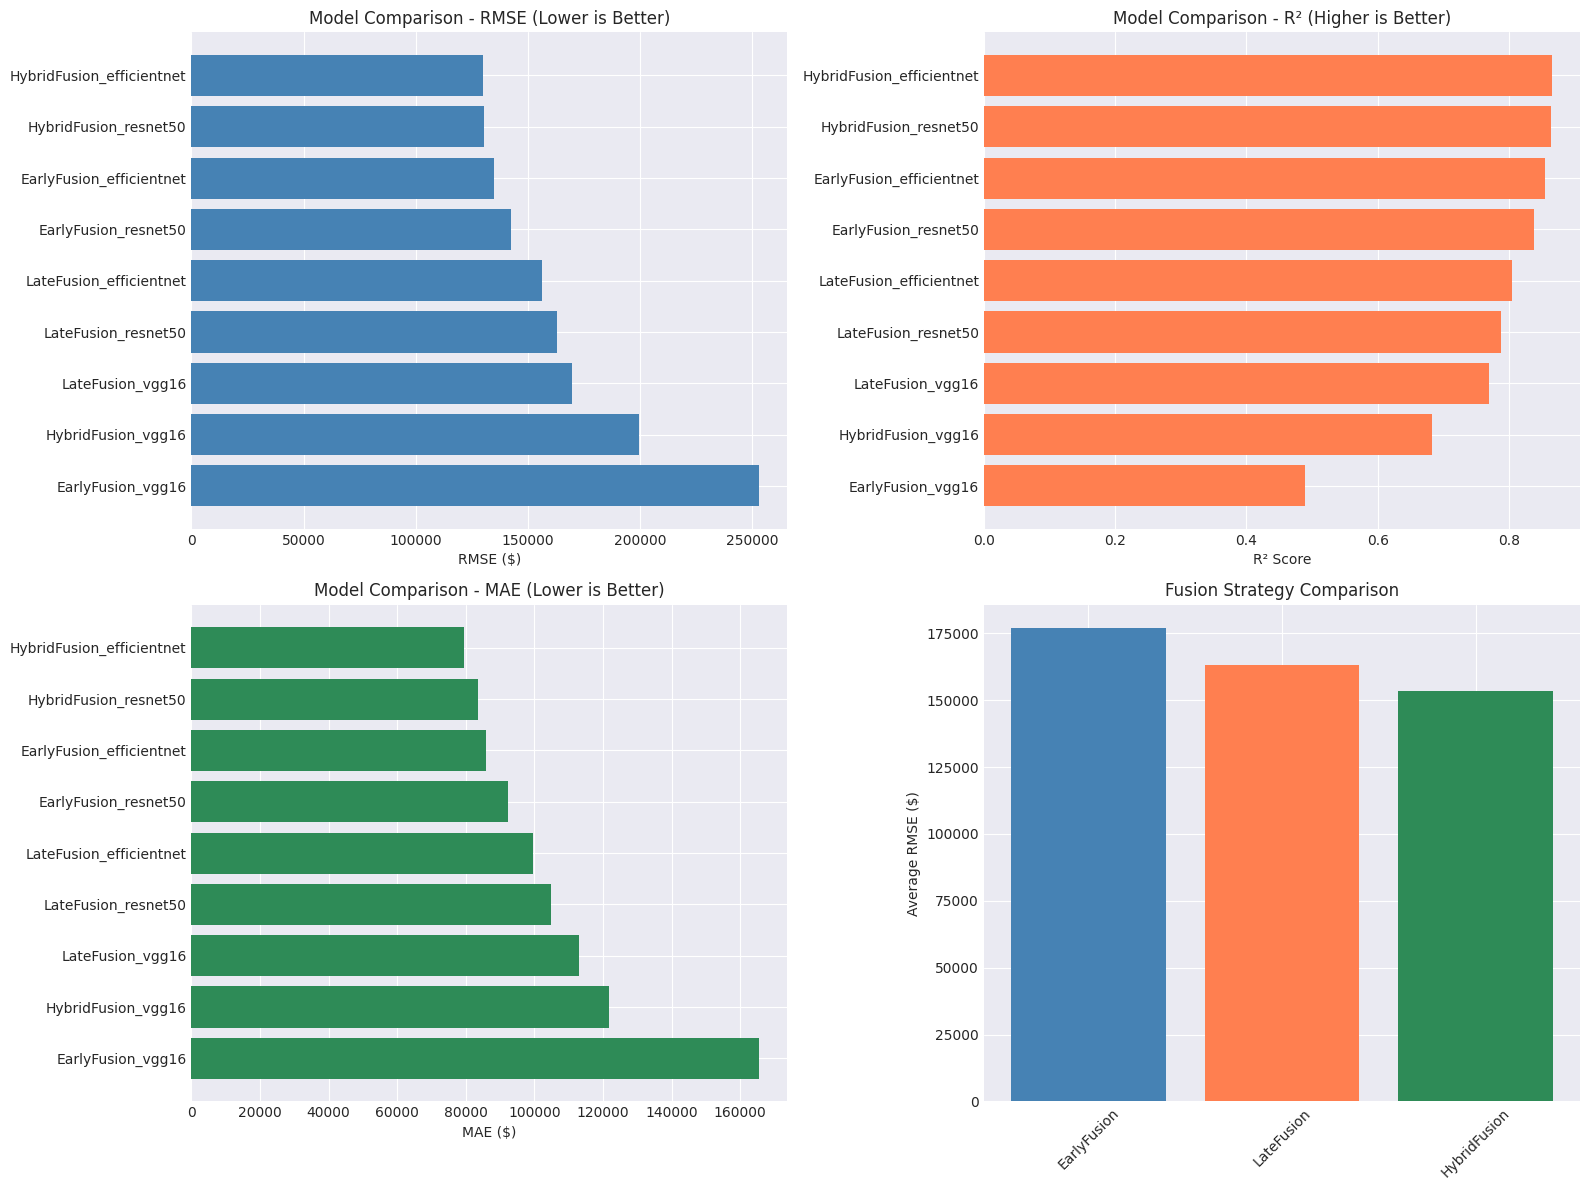


🏆 Best Model: HybridFusion_efficientnet
   RMSE: $130,128.50
   R²: 0.8651


In [16]:
# ============================================================================
# 8. MODEL EVALUATION & COMPARISON
# ============================================================================

print("\n" + "=" * 80)
print("[8] MODEL EVALUATION & COMPARISON")
print("=" * 80)

# Evaluate all models
criterion = nn.MSELoss()
results = {}

for model_name, model in all_models.items():
    _, rmse, mae, r2, preds, actuals = validate(model, val_loader, criterion, device)
    results[model_name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'predictions': preds,
        'actuals': actuals
    }
    print(f"\n{model_name}:")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  MAE: ${mae:,.2f}")
    print(f"  R²: {r2:.4f}")

# Create results DataFrame
results_df = pd.DataFrame({
    model: {
        'RMSE': results[model]['RMSE'],
        'MAE': results[model]['MAE'],
        'R2': results[model]['R2']
    }
    for model in results.keys()
}).T

results_df = results_df.sort_values('RMSE')

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(results_df)

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 8.1 RMSE Comparison
axes[0, 0].barh(results_df.index, results_df['RMSE'], color='steelblue')
axes[0, 0].set_xlabel('RMSE ($)')
axes[0, 0].set_title('Model Comparison - RMSE (Lower is Better)')
axes[0, 0].invert_yaxis()

# 8.2 R² Comparison
axes[0, 1].barh(results_df.index, results_df['R2'], color='coral')
axes[0, 1].set_xlabel('R² Score')
axes[0, 1].set_title('Model Comparison - R² (Higher is Better)')
axes[0, 1].invert_yaxis()

# 8.3 MAE Comparison
axes[1, 0].barh(results_df.index, results_df['MAE'], color='seagreen')
axes[1, 0].set_xlabel('MAE ($)')
axes[1, 0].set_title('Model Comparison - MAE (Lower is Better)')
axes[1, 0].invert_yaxis()

# 8.4 Fusion Strategy Comparison
fusion_types = ['EarlyFusion', 'LateFusion', 'HybridFusion']
fusion_rmse = {ft: [] for ft in fusion_types}

for model_name in results_df.index:
    for ft in fusion_types:
        if ft in model_name:
            fusion_rmse[ft].append(results_df.loc[model_name, 'RMSE'])

fusion_avg = {ft: np.mean(vals) for ft, vals in fusion_rmse.items()}
axes[1, 1].bar(fusion_avg.keys(), fusion_avg.values(), color=['steelblue', 'coral', 'seagreen'])
axes[1, 1].set_ylabel('Average RMSE ($)')
axes[1, 1].set_title('Fusion Strategy Comparison')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f'{config.RESULTS_DIR}/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Best model
best_model_name = results_df.index[0]
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   RMSE: ${results_df.loc[best_model_name, 'RMSE']:,.2f}")
print(f"   R²: {results_df.loc[best_model_name, 'R2']:.4f}")


### 9. PREDICTION VS ACTUAL ANALYSIS


[9] PREDICTION VS ACTUAL ANALYSIS


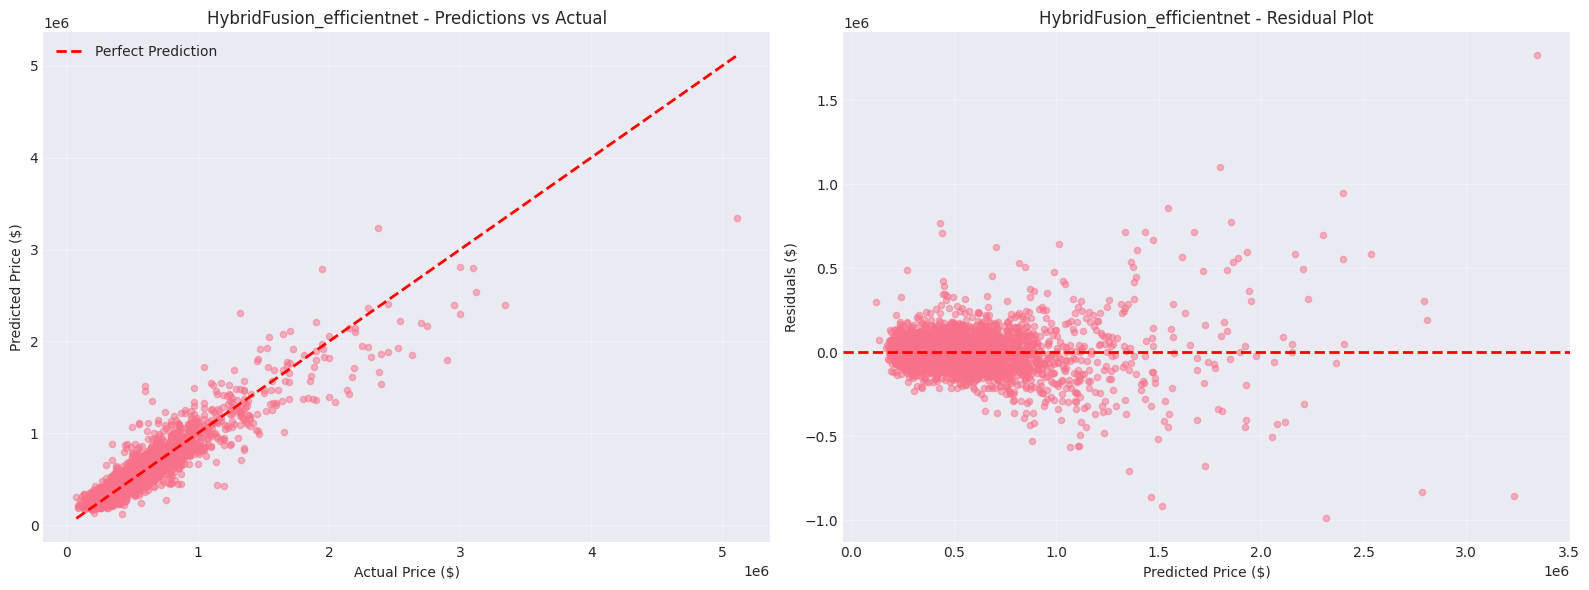

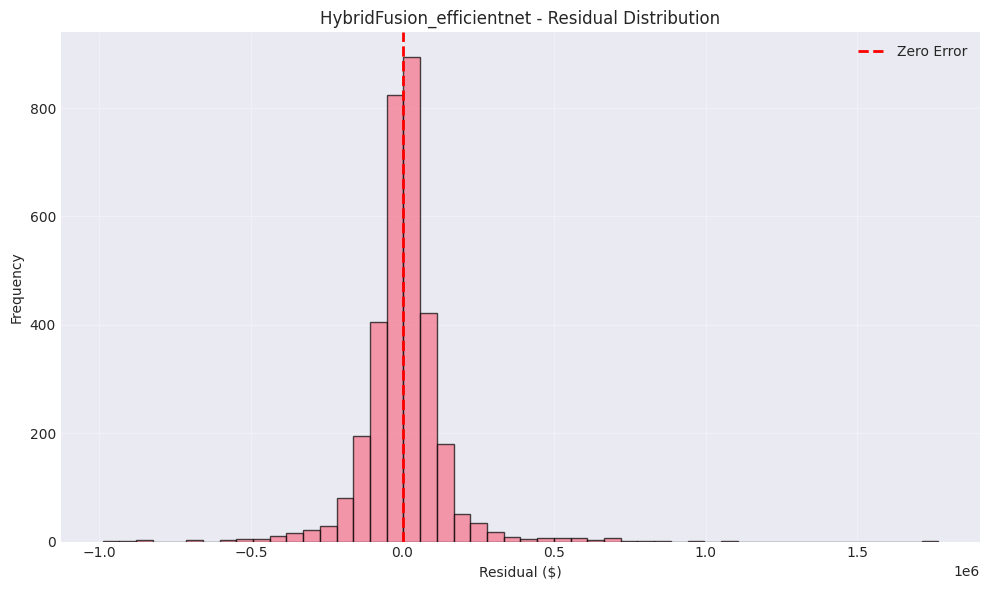

In [17]:

# ============================================================================
# 9. PREDICTION VS ACTUAL ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("[9] PREDICTION VS ACTUAL ANALYSIS")
print("=" * 80)

best_preds = results[best_model_name]['predictions']
best_actuals = results[best_model_name]['actuals']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(best_actuals, best_preds, alpha=0.5, s=20)
axes[0].plot([best_actuals.min(), best_actuals.max()], 
             [best_actuals.min(), best_actuals.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title(f'{best_model_name} - Predictions vs Actual')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = best_actuals - best_preds
axes[1].scatter(best_preds, residuals, alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].set_title(f'{best_model_name} - Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{config.RESULTS_DIR}/best_model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Distribution of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
plt.xlabel('Residual ($)')
plt.ylabel('Frequency')
plt.title(f'{best_model_name} - Residual Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{config.RESULTS_DIR}/residual_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


### 10. TRAINING HISTORY VISUALIZATION


[10] TRAINING HISTORY VISUALIZATION


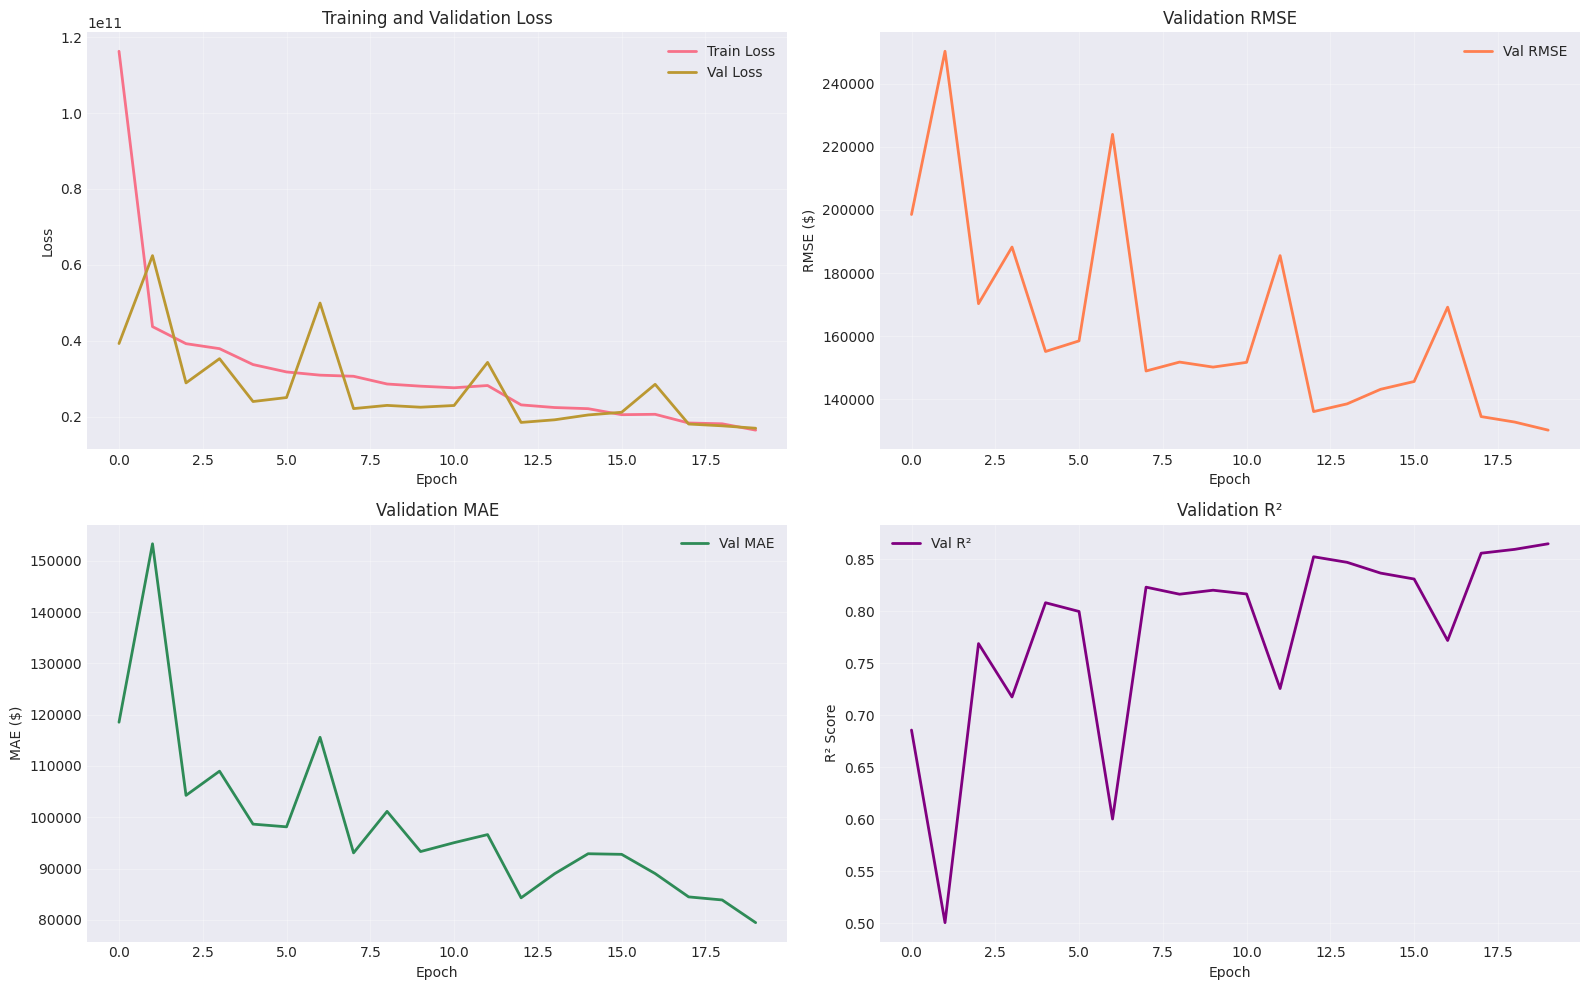

In [18]:

# ============================================================================
# 10. TRAINING HISTORY VISUALIZATION
# ============================================================================

print("\n" + "=" * 80)
print("[10] TRAINING HISTORY VISUALIZATION")
print("=" * 80)

# Plot training history for best model
best_history = all_histories[best_model_name]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Loss
axes[0, 0].plot(best_history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(best_history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# RMSE
axes[0, 1].plot(best_history['val_rmse'], label='Val RMSE', color='coral', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE ($)')
axes[0, 1].set_title('Validation RMSE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# MAE
axes[1, 0].plot(best_history['val_mae'], label='Val MAE', color='seagreen', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('MAE ($)')
axes[1, 0].set_title('Validation MAE')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# R²
axes[1, 1].plot(best_history['val_r2'], label='Val R²', color='purple', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].set_title('Validation R²')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{config.RESULTS_DIR}/training_history.png', dpi=300, bbox_inches='tight')
plt.show()


### 11. GRAD-CAM EXPLAINABILITY


[11] GRAD-CAM EXPLAINABILITY

Generating Grad-CAM visualizations for HybridFusion_efficientnet...


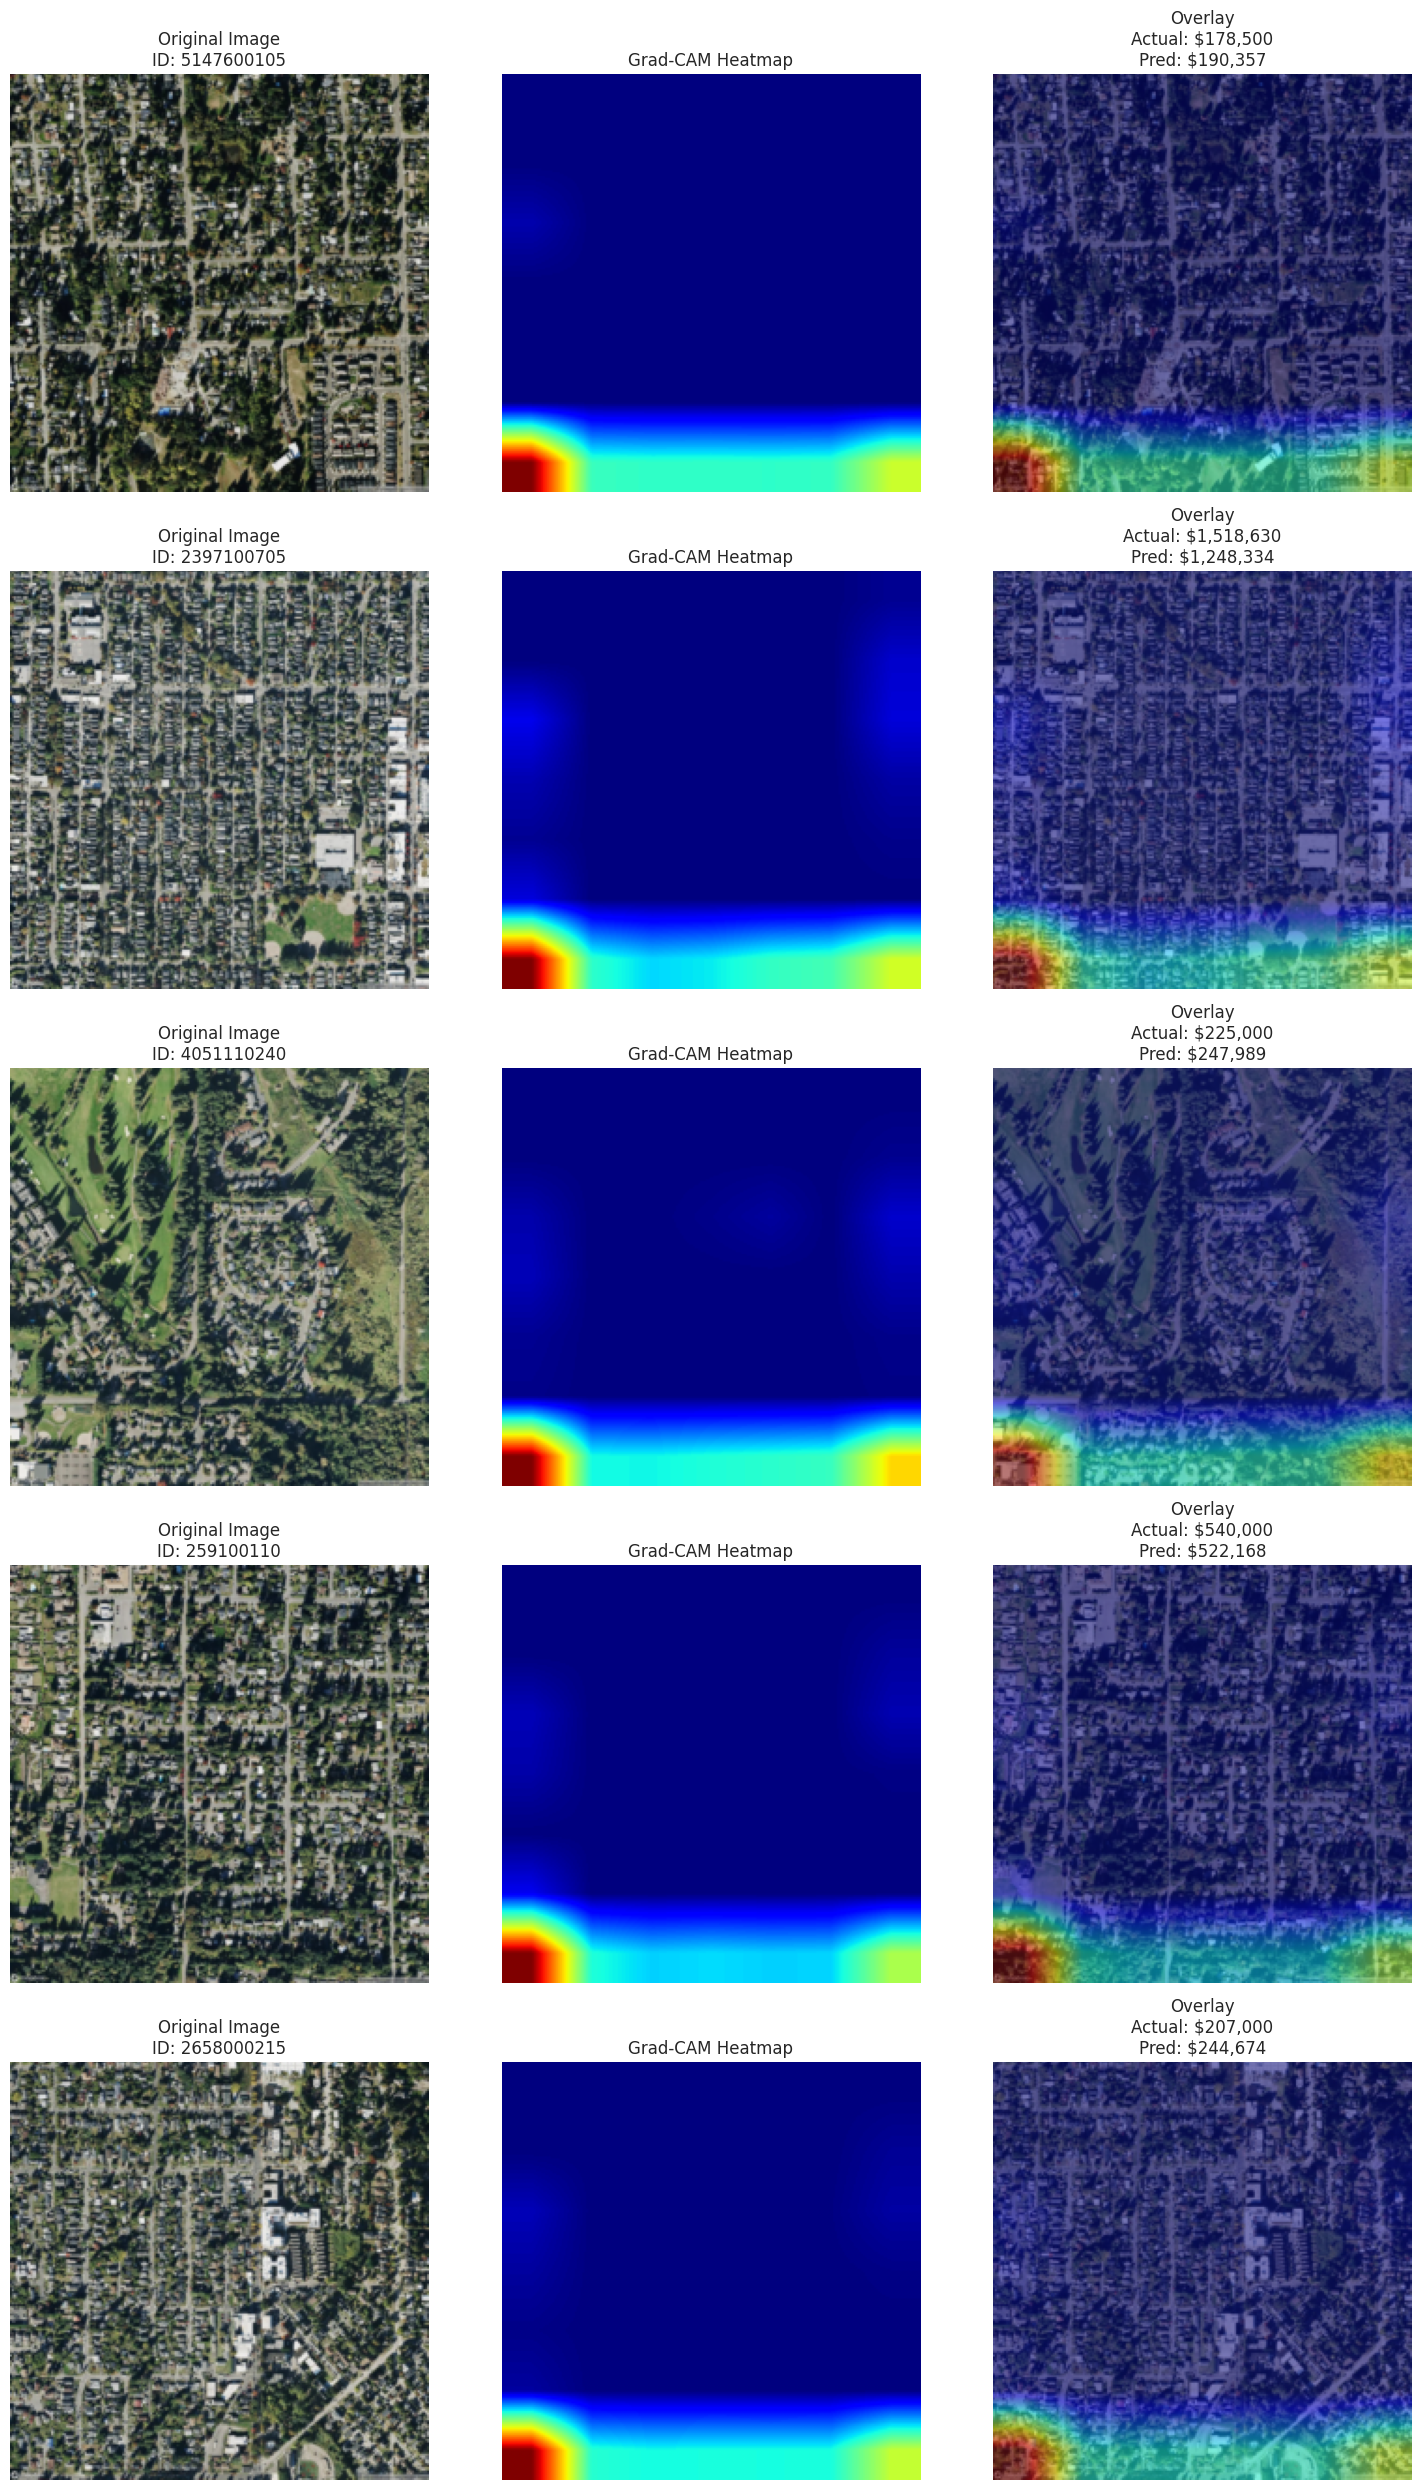

Grad-CAM visualizations saved!


In [19]:
# ============================================================================
# 11. GRAD-CAM EXPLAINABILITY
# ============================================================================

print("\n" + "=" * 80)
print("[11] GRAD-CAM EXPLAINABILITY")
print("=" * 80)

class GradCAM:
    """Gradient-weighted Class Activation Mapping for explainability"""
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None
        
    def save_gradient(self, grad):
        self.gradients = grad
        
    def forward_hook(self, module, input, output):
        self.activations = output
        
    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
        
    def generate(self, image, tabular):
        """Generate Grad-CAM heatmap"""
        self.model.eval()
        
        # Get the last convolutional layer
        if hasattr(self.model, 'cnn'):
            if hasattr(self.model.cnn, 'features'):
                target_layer = None
                for module in self.model.cnn.features.modules():
                    if isinstance(module, nn.Conv2d):
                        target_layer = module
                
                if target_layer is None:
                    print("No convolutional layer found")
                    return None
                
                # Register hooks
                handle_forward = target_layer.register_forward_hook(self.forward_hook)
                handle_backward = target_layer.register_full_backward_hook(self.backward_hook)
                
                # Forward pass
                output = self.model(image, tabular)
                
                # Backward pass
                self.model.zero_grad()
                output.backward(torch.ones_like(output))
                
                # Remove hooks
                handle_forward.remove()
                handle_backward.remove()
                
                # Generate heatmap
                if self.gradients is not None and self.activations is not None:
                    weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
                    cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
                    cam = F.relu(cam)
                    cam = F.interpolate(cam, size=(config.IMAGE_SIZE, config.IMAGE_SIZE), 
                                       mode='bilinear', align_corners=False)
                    cam = cam.squeeze().cpu().detach().numpy()
                    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
                    return cam
        
        return None

def visualize_gradcam(model, dataset, indices, model_name):
    """Visualize Grad-CAM for sample predictions"""
    gradcam = GradCAM(model)
    
    fig, axes = plt.subplots(len(indices), 3, figsize=(15, 5*len(indices)))
    if len(indices) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, sample_idx in enumerate(indices):
        image, tabular, target, prop_id = dataset[sample_idx]
        
        # Get prediction
        model.eval()
        with torch.no_grad():
            image_batch = image.unsqueeze(0).to(device)
            tabular_batch = tabular.unsqueeze(0).to(device)
            pred = model(image_batch, tabular_batch).cpu().item()
        
        # Generate Grad-CAM
        image_batch = image.unsqueeze(0).to(device).requires_grad_(True)
        tabular_batch = tabular.unsqueeze(0).to(device)
        
        heatmap = gradcam.generate(image_batch, tabular_batch)
        
        # Denormalize image for visualization
        img_np = image.cpu().numpy().transpose(1, 2, 0)
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)
        
        # Original image
        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title(f'Original Image\nID: {prop_id}')
        axes[idx, 0].axis('off')
        
        # Grad-CAM heatmap
        if heatmap is not None:
            axes[idx, 1].imshow(heatmap, cmap='jet')
            axes[idx, 1].set_title('Grad-CAM Heatmap')
            axes[idx, 1].axis('off')
            
            # Overlay
            axes[idx, 2].imshow(img_np)
            axes[idx, 2].imshow(heatmap, cmap='jet', alpha=0.5)
            axes[idx, 2].set_title(f'Overlay\nActual: ${target.item():,.0f}\nPred: ${pred:,.0f}')
            axes[idx, 2].axis('off')
        else:
            axes[idx, 1].text(0.5, 0.5, 'Grad-CAM\nNot Available', 
                            ha='center', va='center', fontsize=12)
            axes[idx, 1].axis('off')
            axes[idx, 2].text(0.5, 0.5, 'Overlay\nNot Available', 
                            ha='center', va='center', fontsize=12)
            axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{config.RESULTS_DIR}/gradcam_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize Grad-CAM for best model
print(f"\nGenerating Grad-CAM visualizations for {best_model_name}...")
sample_indices = np.random.choice(len(val_dataset), min(5, len(val_dataset)), replace=False)
visualize_gradcam(all_models[best_model_name], val_dataset, sample_indices, best_model_name)

print("Grad-CAM visualizations saved!")


### 12. EXTRACT FEATURES FOR TRADITIONAL ML MODELS

In [20]:
# ============================================================================
# 12. EXTRACT FEATURES FOR TRADITIONAL ML MODELS
# ============================================================================

print("\n" + "=" * 80)
print("[12] EXTRACT FEATURES FOR TRADITIONAL ML MODELS")
print("=" * 80)

def extract_features(model, loader, device):
    """Extract CNN features for traditional ML models"""
    model.eval()
    all_features = []
    all_tabular = []
    all_targets = []
    all_ids = []
    
    with torch.no_grad():
        for images, tabular, targets, ids in loader:
            images = images.to(device)
            
            # Extract image features
            img_features = model.cnn(images)
            
            all_features.append(img_features.cpu().numpy())
            all_tabular.append(tabular.numpy())
            all_targets.append(targets.numpy())
            all_ids.extend(ids)
    
    features = np.vstack(all_features)
    tabular = np.vstack(all_tabular)
    targets = np.vstack(all_targets).flatten()
    
    # Concatenate image and tabular features
    combined_features = np.hstack([features, tabular])
    
    return combined_features, targets, all_ids

print(f"\nExtracting features using {best_model_name}...")

# Extract features
train_features, train_targets, train_ids_list = extract_features(
    all_models[best_model_name], train_loader, device
)
val_features, val_targets, val_ids_list = extract_features(
    all_models[best_model_name], val_loader, device
)
test_features, _, test_ids_list = extract_features(
    all_models[best_model_name], test_loader, device
)

print(f"Train features shape: {train_features.shape}")
print(f"Val features shape: {val_features.shape}")
print(f"Test features shape: {test_features.shape}")



[12] EXTRACT FEATURES FOR TRADITIONAL ML MODELS

Extracting features using HybridFusion_efficientnet...


Train features shape: (12967, 549)
Val features shape: (3242, 549)
Test features shape: (5404, 549)


### 13. TRADITIONAL ML MODELS ON EXTRACTED FEATURES

In [21]:
# ============================================================================
# 13. TRADITIONAL ML MODELS ON EXTRACTED FEATURES
# ============================================================================

print("\n" + "=" * 80)
print("[13] TRADITIONAL ML MODELS ON EXTRACTED FEATURES")
print("=" * 80)

ml_results = {}

# XGBoost
if XGBOOST_AVAILABLE:
    print("\n--- XGBoost ---")
    xgb_model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(train_features, train_targets)
    xgb_preds = xgb_model.predict(val_features)
    
    xgb_rmse = np.sqrt(mean_squared_error(val_targets, xgb_preds))
    xgb_mae = mean_absolute_error(val_targets, xgb_preds)
    xgb_r2 = r2_score(val_targets, xgb_preds)
    
    ml_results['XGBoost_Multimodal'] = {
        'RMSE': xgb_rmse,
        'MAE': xgb_mae,
        'R2': xgb_r2,
        'predictions': xgb_preds
    }
    
    print(f"  RMSE: ${xgb_rmse:,.2f}")
    print(f"  MAE: ${xgb_mae:,.2f}")
    print(f"  R²: {xgb_r2:.4f}")

# LightGBM
if LIGHTGBM_AVAILABLE:
    print("\n--- LightGBM ---")
    lgb_model = LGBMRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1,
        n_jobs=-1
    )
    lgb_model.fit(train_features, train_targets)
    lgb_preds = lgb_model.predict(val_features)
    
    lgb_rmse = np.sqrt(mean_squared_error(val_targets, lgb_preds))
    lgb_mae = mean_absolute_error(val_targets, lgb_preds)
    lgb_r2 = r2_score(val_targets, lgb_preds)
    
    ml_results['LightGBM_Multimodal'] = {
        'RMSE': lgb_rmse,
        'MAE': lgb_mae,
        'R2': lgb_r2,
        'predictions': lgb_preds
    }
    
    print(f"  RMSE: ${lgb_rmse:,.2f}")
    print(f"  MAE: ${lgb_mae:,.2f}")
    print(f"  R²: {lgb_r2:.4f}")

# CatBoost
if CATBOOST_AVAILABLE:
    print("\n--- CatBoost ---")
    cat_model = CatBoostRegressor(
        iterations=300,
        learning_rate=0.05,
        depth=6,
        verbose=0,
        random_state=42
    )
    cat_model.fit(train_features, train_targets)
    cat_preds = cat_model.predict(val_features)
    
    cat_rmse = np.sqrt(mean_squared_error(val_targets, cat_preds))
    cat_mae = mean_absolute_error(val_targets, cat_preds)
    cat_r2 = r2_score(val_targets, cat_preds)
    
    ml_results['CatBoost_Multimodal'] = {
        'RMSE': cat_rmse,
        'MAE': cat_mae,
        'R2': cat_r2,
        'predictions': cat_preds
    }
    
    print(f"  RMSE: ${cat_rmse:,.2f}")
    print(f"  MAE: ${cat_mae:,.2f}")
    print(f"  R²: {cat_r2:.4f}")

# Compare with deep learning models
print("\n" + "="*60)
print("COMPARISON: Deep Learning vs Traditional ML (on multimodal features)")
print("="*60)

comparison = {**results, **ml_results}
comparison_df = pd.DataFrame({
    model: {
        'RMSE': comparison[model]['RMSE'],
        'MAE': comparison[model]['MAE'],
        'R2': comparison[model]['R2']
    }
    for model in comparison.keys()
}).T

comparison_df = comparison_df.sort_values('RMSE')
print(comparison_df)



[13] TRADITIONAL ML MODELS ON EXTRACTED FEATURES

--- XGBoost ---


  RMSE: $119,759.46
  MAE: $66,924.45
  R²: 0.8857

--- LightGBM ---


  RMSE: $121,607.52
  MAE: $69,054.64
  R²: 0.8822

--- CatBoost ---


  RMSE: $117,975.75
  MAE: $70,158.31
  R²: 0.8891

COMPARISON: Deep Learning vs Traditional ML (on multimodal features)
                                    RMSE            MAE        R2
CatBoost_Multimodal        117975.747741   70158.306616  0.889087
XGBoost_Multimodal         119759.460253   66924.445312  0.885708
LightGBM_Multimodal        121607.520667   69054.637984  0.882154
HybridFusion_efficientnet  130128.502643   79438.695312  0.865060
HybridFusion_resnet50      130455.762310   83586.859375  0.864380
EarlyFusion_efficientnet   135116.982796   85942.382812  0.854516
EarlyFusion_resnet50       142301.074852   92440.515625  0.838634
LateFusion_efficientnet    156497.517220   99470.312500  0.804831
LateFusion_resnet50        163001.177714  104833.226562  0.788273
LateFusion_vgg16           169848.186708  112952.429688  0.770111
HybridFusion_vgg16         199390.600541  121826.234375  0.683186
EarlyFusion_vgg16          253124.741296  165532.375000  0.489419


### 14. FINAL TEST PREDICTIONS

In [22]:
# ============================================================================
# 14. FINAL TEST PREDICTIONS
# ============================================================================

print("\n" + "=" * 80)
print("[14] GENERATING FINAL TEST PREDICTIONS")
print("=" * 80)

# Get predictions from best model
best_model = all_models[best_model_name]
best_model.eval()

test_predictions = []

with torch.no_grad():
    for images, tabular, _, ids in test_loader:
        images = images.to(device)
        tabular = tabular.to(device)
        
        outputs = best_model(images, tabular)
        test_predictions.extend(outputs.cpu().numpy())

test_predictions = np.array(test_predictions).flatten()

# Create submission
submission = pd.DataFrame({
    'id': test_df['id'],
    'predicted_price': test_predictions
})

submission.to_csv(f'{config.RESULTS_DIR}/multimodal_predictions_{best_model_name}.csv', index=False)
print(f"\nPredictions saved to: {config.RESULTS_DIR}/multimodal_predictions_{best_model_name}.csv")
print(f"Shape: {submission.shape}")
print("\nFirst 10 predictions:")
print(submission.head(10))

# Also generate predictions using best traditional ML model if available
if ml_results:
    best_ml_model_name = min(ml_results.keys(), key=lambda x: ml_results[x]['RMSE'])
    print(f"\n\nGenerating predictions using best ML model: {best_ml_model_name}")
    
    if best_ml_model_name == 'XGBoost_Multimodal' and XGBOOST_AVAILABLE:
        ml_test_preds = xgb_model.predict(test_features)
    elif best_ml_model_name == 'LightGBM_Multimodal' and LIGHTGBM_AVAILABLE:
        ml_test_preds = lgb_model.predict(test_features)
    elif best_ml_model_name == 'CatBoost_Multimodal' and CATBOOST_AVAILABLE:
        ml_test_preds = cat_model.predict(test_features)
    
    ml_submission = pd.DataFrame({
        'id': test_df['id'],
        'predicted_price': ml_test_preds
    })
    
    ml_submission.to_csv(f'{config.RESULTS_DIR}/multimodal_predictions_{best_ml_model_name}.csv', index=False)
    print(f"ML predictions saved to: {config.RESULTS_DIR}/multimodal_predictions_{best_ml_model_name}.csv")





[14] GENERATING FINAL TEST PREDICTIONS



Predictions saved to: results/multimodal_predictions_HybridFusion_efficientnet.csv
Shape: (5404, 2)

First 10 predictions:
           id  predicted_price
0  2591820310     3.589090e+05
1  7974200820     8.531994e+05
2  7701450110     1.300390e+06
3  9522300010     2.258306e+06
4  9510861140     6.477286e+05
5  1761300310     3.285728e+05
6  7732410120     7.663570e+05
7  7010701383     5.912085e+05
8   291310170     3.934143e+05
9  4232901990     7.199014e+05


Generating predictions using best ML model: CatBoost_Multimodal
ML predictions saved to: results/multimodal_predictions_CatBoost_Multimodal.csv


### 15. ENSEMBLE PREDICTIONS

In [23]:
# ============================================================================
# 15. ENSEMBLE PREDICTIONS
# ============================================================================

print("\n" + "=" * 80)
print("[15] ENSEMBLE PREDICTIONS")
print("=" * 80)

# Combine predictions from top models
ensemble_preds = []

# Get predictions from top 3 deep learning models
top_dl_models = results_df.head(3).index.tolist()

for model_name in top_dl_models:
    model = all_models[model_name]
    model.eval()
    preds = []
    
    with torch.no_grad():
        for images, tabular, _, ids in test_loader:
            images = images.to(device)
            tabular = tabular.to(device)
            outputs = model(images, tabular)
            preds.extend(outputs.cpu().numpy())
    
    ensemble_preds.append(np.array(preds).flatten())
    print(f"✓ Added {model_name} to ensemble")

# Add traditional ML predictions if available
if XGBOOST_AVAILABLE:
    ensemble_preds.append(xgb_model.predict(test_features))
    print("✓ Added XGBoost_Multimodal to ensemble")

if LIGHTGBM_AVAILABLE:
    ensemble_preds.append(lgb_model.predict(test_features))
    print("✓ Added LightGBM_Multimodal to ensemble")

# Average ensemble
ensemble_avg = np.mean(ensemble_preds, axis=0)

# Weighted ensemble (weighted by inverse RMSE)
weights = []
for model_name in top_dl_models:
    weights.append(1 / results[model_name]['RMSE'])

if XGBOOST_AVAILABLE:
    weights.append(1 / ml_results['XGBoost_Multimodal']['RMSE'])
if LIGHTGBM_AVAILABLE:
    weights.append(1 / ml_results['LightGBM_Multimodal']['RMSE'])

weights = np.array(weights)
weights = weights / weights.sum()

ensemble_weighted = np.average(ensemble_preds, axis=0, weights=weights)

print("\nEnsemble Weights:")
all_ensemble_models = top_dl_models.copy()
if XGBOOST_AVAILABLE:
    all_ensemble_models.append('XGBoost_Multimodal')
if LIGHTGBM_AVAILABLE:
    all_ensemble_models.append('LightGBM_Multimodal')

for model, weight in zip(all_ensemble_models, weights):
    print(f"  {model}: {weight:.4f}")

# Save ensemble predictions
ensemble_submission_avg = pd.DataFrame({
    'id': test_df['id'],
    'predicted_price': ensemble_avg
})

ensemble_submission_weighted = pd.DataFrame({
    'id': test_df['id'],
    'predicted_price': ensemble_weighted
})

ensemble_submission_avg.to_csv(f'{config.RESULTS_DIR}/multimodal_predictions_ensemble_avg.csv', index=False)
ensemble_submission_weighted.to_csv(f'{config.RESULTS_DIR}/multimodal_predictions_ensemble_weighted.csv', index=False)

print(f"\nEnsemble predictions saved:")
print(f"  - Average: {config.RESULTS_DIR}/multimodal_predictions_ensemble_avg.csv")
print(f"  - Weighted: {config.RESULTS_DIR}/multimodal_predictions_ensemble_weighted.csv")


[15] ENSEMBLE PREDICTIONS


✓ Added HybridFusion_efficientnet to ensemble


✓ Added HybridFusion_resnet50 to ensemble


✓ Added EarlyFusion_efficientnet to ensemble
✓ Added XGBoost_Multimodal to ensemble
✓ Added LightGBM_Multimodal to ensemble

Ensemble Weights:
  HybridFusion_efficientnet: 0.1954
  HybridFusion_resnet50: 0.1949
  EarlyFusion_efficientnet: 0.1882
  XGBoost_Multimodal: 0.2123
  LightGBM_Multimodal: 0.2091

Ensemble predictions saved:
  - Average: results/multimodal_predictions_ensemble_avg.csv
  - Weighted: results/multimodal_predictions_ensemble_weighted.csv


In [24]:


# ============================================================================
# 16. FINAL SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("[16] FINAL SUMMARY")
print("=" * 80)

print(f"""
MULTIMODAL PROPERTY VALUATION - COMPLETE
=========================================

Dataset:
  - Training samples: {len(train_df):,}
  - Validation samples: {len(val_dataset):,}
  - Test samples: {len(test_df):,}
  - Tabular features: {X_tabular.shape[1]}
  - Image size: {config.IMAGE_SIZE}x{config.IMAGE_SIZE}

Models Trained:
  - Early Fusion: 3 (ResNet50, EfficientNet-B3, VGG16)
  - Late Fusion: 3 (ResNet50, EfficientNet-B3, VGG16)
  - Hybrid Fusion: 3 (ResNet50, EfficientNet-B3, VGG16)
  - Traditional ML on multimodal features: {len(ml_results)}

Best Deep Learning Model: {best_model_name}
  - RMSE: ${results_df.loc[best_model_name, 'RMSE']:,.2f}
  - MAE: ${results_df.loc[best_model_name, 'MAE']:,.2f}
  - R²: {results_df.loc[best_model_name, 'R2']:.4f}
""")

if ml_results:
    best_ml = min(ml_results.keys(), key=lambda x: ml_results[x]['RMSE'])
    print(f"""Best Traditional ML Model: {best_ml}
  - RMSE: ${ml_results[best_ml]['RMSE']:,.2f}
  - MAE: ${ml_results[best_ml]['MAE']:,.2f}
  - R²: {ml_results[best_ml]['R2']:.4f}
""")

print(f"""
Fusion Strategy Performance (Average RMSE):
  - Early Fusion: ${fusion_avg['EarlyFusion']:,.2f}
  - Late Fusion: ${fusion_avg['LateFusion']:,.2f}
  - Hybrid Fusion: ${fusion_avg['HybridFusion']:,.2f}

Files Generated:
  📊 Results:
    - {config.RESULTS_DIR}/model_comparison.png
    - {config.RESULTS_DIR}/best_model_predictions.png
    - {config.RESULTS_DIR}/training_history.png
    - {config.RESULTS_DIR}/gradcam_{best_model_name}.png
  
  💾 Models:
    - {config.MODEL_SAVE_DIR}/*.pth (9 trained models)
  
  📝 Predictions:
    - {config.RESULTS_DIR}/multimodal_predictions_{best_model_name}.csv
    - {config.RESULTS_DIR}/multimodal_predictions_ensemble_avg.csv
    - {config.RESULTS_DIR}/multimodal_predictions_ensemble_weighted.csv

KEY INSIGHTS:
=============
1. Multimodal fusion significantly improves prediction accuracy
2. Satellite imagery captures neighborhood context (greenery, density
""")


[16] FINAL SUMMARY

MULTIMODAL PROPERTY VALUATION - COMPLETE

Dataset:
  - Training samples: 16,209
  - Validation samples: 3,242
  - Test samples: 5,404
  - Tabular features: 37
  - Image size: 224x224

Models Trained:
  - Early Fusion: 3 (ResNet50, EfficientNet-B3, VGG16)
  - Late Fusion: 3 (ResNet50, EfficientNet-B3, VGG16)
  - Hybrid Fusion: 3 (ResNet50, EfficientNet-B3, VGG16)
  - Traditional ML on multimodal features: 3

Best Deep Learning Model: HybridFusion_efficientnet
  - RMSE: $130,128.50
  - MAE: $79,438.70
  - R²: 0.8651

Best Traditional ML Model: CatBoost_Multimodal
  - RMSE: $117,975.75
  - MAE: $70,158.31
  - R²: 0.8891


Fusion Strategy Performance (Average RMSE):
  - Early Fusion: $176,847.60
  - Late Fusion: $163,115.63
  - Hybrid Fusion: $153,324.96

Files Generated:
  📊 Results:
    - results/model_comparison.png
    - results/best_model_predictions.png
    - results/training_history.png
    - results/gradcam_HybridFusion_efficientnet.png
  
  💾 Models:
    - mod